# Customer Churn - 6-Month Look Ahead Prediction

## The Business Problem

Companies face significant challenges with customer churn - customers closing accounts and moving to competitors. Understanding what factors drive this decision allows management to focus improvement efforts where they matter most. My objective is to build a neural network classifier that predicts whether a customer will leave the bank in the next 6 months.  The techniques I use below are to measure bank customer churn, though this can be applied to many other industries.

In this notebook, I'll walk through my process of building, evaluating, and optimizing neural network models to predict whether a bank customer will leave in the next 6 months. This kind of prediction is extremely valuable for businesses as customer retention is often more cost-effective than acquisition.

### Model Optimization Strategy:

1. Build the Neural Network model with SGD as an optimizer (Model 1).
2. Use different methods mentioned below to improve the model by finding the optimal threshold using ROC-AUC curves for each of the methods.
    - Build a model with Adam optimizer (Model 2).
    - Build a model with Dropout and Adam optimizer (Model 3).
    - Build model with Hyperparameter tuning using Grid search and Adam optimizer (Model 4).
    - Build a model with balanced data by applying SMOTE and Adam optimizer (Model 5).
3. Choose the best model from the ones built for optimizing prediction of customer churn.

---
---
---

## TL;DR - Analysis and Conclusion

After building and comparing five different neural network models, I've concluded that **Model 4 (Hyperparameter Tuning with Adam optimizer)** performs the best overall. Here's why:

- It achieved the highest ROC AUC score of 0.85
- The recall for the churn class (1) is 0.75, which is crucial for this business problem
- The precision-recall balance is better suited for identifying customers at risk of churning

**The final classification report for our chosen model (Model 4) shows:**


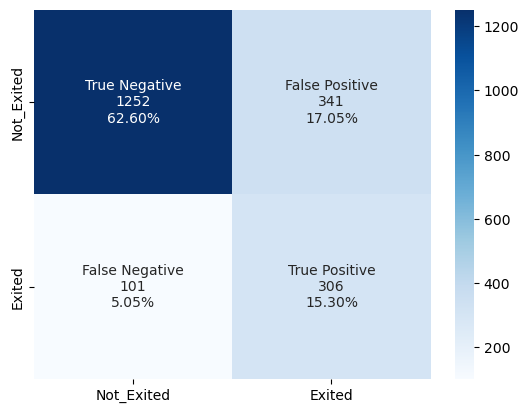

```
precision    recall  f1-score   support

           0       0.93      0.79      0.85      1593
           1       0.47      0.75      0.58       407

    accuracy                           0.78      2000
   macro avg       0.70      0.77      0.72      2000
weighted avg       0.83      0.78      0.80      2000
```

While the overall accuracy is 78%, what's most important here is the high recall (75%) for the churn class. This means our model is quite good at identifying customers who will actually leave, which is what matters most to the business. We'd rather flag some false positives (customers predicted to leave who actually stay) than miss customers who are about to churn.

The confusion matrix visually confirms this trade-off, showing that most of our misclassifications are false positives rather than false negatives.

### Next Steps for Production Deployment

I would approach productionizing this model as follows:

1. Model Refinement:

- Experiment with additional features or transformations
- Try ensemble methods combining multiple models
- Investigate more sophisticated neural network architectures


2. MLOps Pipeline:

- Containerize the solution using Docker for consistent environments
- Set up CI/CD pipeline for model training and deployment
- Implement model versioning and A/B testing capabilities

3. Monitoring and Maintenance:

- Deploy monitoring for concept drift detection
- Set up automated retraining when performance degrades
- Create dashboards for business stakeholders

4. Explainability and Trust:

- Generate customer profiles to help the business understand who's likely to churn
- Create actionable insights for customer retention strategies
- Measure model against arbitrary biases.

5. Scalability:

- Optimize prediction latency for real-time applications
- Implement batch prediction capabilities for large customer cohorts
- Design the system to handle growing data volumes

As we can surmise, there is considerable effort to take a model to production.  Bringing my experience as a full-stack software engineer, I would leverage AI in the step-by-step develop where appropriate to accelerate business value.

----

## Detailed Full Analysis

For the remainder of this Jupyter notebook, I will walk through the step-by-step of how I trained, evaluated and selected Model 4.


### Data Dictionary: 

* CustomerId: Unique ID which is assigned to each customer

* Surname: Last name of the customer
 
* CreditScore: It defines the credit history of the customer.
  
* Geography: A customer’s location 
   
* Gender: It defines the Gender of the customer
   
* Age: Age of the customer 
    
* Tenure: Number of years for which the customer has been with the bank

* NumOfProducts: refers to the number of products that a customer has purchased through the bank.

* Balance: Account balance

* HasCrCard: It is a categorical variable which decides whether the customer has credit card or not.

* EstimatedSalary: Estimated salary 

* isActiveMember: Is is a categorical variable which decides whether the customer is active member of the bank or not ( Active member in the sense, using bank products regularly, making transactions etc )

* Exited : whether or not the customer left the bank within six month. It can take two values 
** 0=No ( Customer did not leave the bank )
** 1=Yes ( Customer left the bank )

## Importing necessary libraries

In [590]:
# Libraries of reading and manipulating data
import pandas as pd
import numpy as np

# Display data
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

# Import Plotly to help build EDA data visualizatios
import plotly
import plotly.express as px
import plotly.io as pio

# SciKit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn import model_selection
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

import sklearn

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

from sklearn import metrics

# Gather model tuning metrics
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    ConfusionMatrixDisplay,
)

# Handle imbalanced data with oversampling | undersampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Tensorflow/Keras model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dense, Input, Dropout,BatchNormalization
from tensorflow.keras import backend

# Keras classback API
from keras import callbacks

# suppress Tensorflow warnings
tf.get_logger().setLevel('ERROR')

import warnings
warnings.filterwarnings('ignore')


# random seed gnerator
import random

# Jupyter notebook output formatting
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Plotly config 
pio.renderers.default='notebook'

# Initialize random seed
random.seed(99)
np.random.seed(99) 
tf.random.set_seed(99)

In [3]:
# deprecated: tensorflow.keras.wrappers.scikit_learn import KerasClassifier
# using SciKeras instead. ref: https://adriangb.com/scikeras/stable/migration.html

!pip install scikeras

  Obtaining dependency information for tensorflow-metal<2.0.0,>=1.1.0 from https://files.pythonhosted.org/packages/52/56/8373f5751011304a346f07e5423e69f809b626989d2541ae9e816ae7ced2/tensorflow_metal-1.1.0-cp311-cp311-macosx_12_0_arm64.whl.metadata
  Using cached tensorflow_metal-1.1.0-cp311-cp311-macosx_12_0_arm64.whl.metadata (1.2 kB)
Using cached tensorflow_metal-1.1.0-cp311-cp311-macosx_12_0_arm64.whl (1.4 MB)


In [4]:
# deprecated: tensorflow.keras.wrappers.scikit_learn import KerasClassifier
# using SciKeras instead. ref: https://adriangb.com/scikeras/stable/migration.html

from scikeras.wrappers import KerasClassifier


### Following code needed to render Plotly to HTML saved notebooks

In [5]:
%%HTML
<script src="https://unpkg.com/requirejs@2.3.6/bin/r.js"></script>

### Check package versions

In [6]:
# check that the libraries loaded properly

print('pandas version: {}'.format(pd.__version__))
print('seaborn version: {}'.format(sns.__version__))
print('numpy version: {}'.format(np.__version__))
print('sklearn version: {}'.format(sklearn.__version__))
print('matplotlib version: {}'.format(matplotlib.__version__))
print('Plotly version: {}'.format(plotly.__version__))
print(f'Tensorflow version: {tf.__version__}')

pandas version: 1.5.3
seaborn version: 0.12.2
numpy version: 1.24.3
sklearn version: 1.3.0
matplotlib version: 3.7.1
Plotly version: 5.9.0
Tensorflow version: 2.15.0


## Loading the dataset

In [7]:
data = pd.read_csv('./data/DATA_WORK_NN_PROJ4_bank_churn.csv')

## Data Overview | Observe and Assess the Shape of the Data

- Data observations
- Assess the shape of the dataset
- Sanity checks
- Check for null values
- Check for duplicates


In [8]:
print('Bank Customer Churn dataset contains {} rows and {} columns.'.format(data.shape[0], data.shape[1]))

Bank Customer Churn dataset contains 10000 rows and 14 columns.


In [9]:
data.head(15)

RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0           1    15634602  Hargrave          619    France  Female   42   
1           2    15647311      Hill          608     Spain  Female   41   
2           3    15619304      Onio          502    France  Female   42   
3           4    15701354      Boni          699    France  Female   39   
4           5    15737888  Mitchell          850     Spain  Female   43   
5           6    15574012       Chu          645     Spain    Male   44   
6           7    15592531  Bartlett          822    France    Male   50   
7           8    15656148    Obinna          376   Germany  Female   29   
8           9    15792365        He          501    France    Male   44   
9          10    15592389        H?          684    France    Male   27   
10         11    15767821    Bearce          528    France    Male   31   
11         12    15737173   Andrews          497     Spain    Male   24   
12         13    15632264       Kay          476    France  Female   34   
13         14    15691483      Chin          549    France  Female   25   
14         15    15600882     Scott          635     Spain  Female   35   

    Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0        2       0.00              1          1               1   
1        1   83807.86              1          0               1   
2        8  159660.80              3          1               0   
3        1       0.00              2          0               0   
4        2  125510.82              1          1               1   
5        8  113755.78              2          1               0   
6        7       0.00              2          1               1   
7        4  115046.74              4          1               0   
8        4  142051.07              2          0               1   
9        2  134603.88              1          1               1   
10       6  102016.72              2          0               0   
11       3       0.00              2          1               0   
12      10       0.00              2          1               0   
13       5       0.00              2          0               0   
14       7       0.00              2          1               1   

    EstimatedSalary  Exited  
0         101348.88       1  
1         112542.58       0  
2         113931.57       1  
3          93826.63       0  
4          79084.10       0  
5         149756.71       1  
6          10062.80       0  
7         119346.88       1  
8          74940.50       0  
9          71725.73       0  
10         80181.12       0  
11         76390.01       0  
12         26260.98       0  
13        190857.79       0  
14         65951.65       0

In [10]:
data.tail(15)

RowNumber  CustomerId      Surname  CreditScore Geography  Gender  Age  \
9985       9986    15586914       Nepean          659    France    Male   36   
9986       9987    15581736     Bartlett          673   Germany    Male   47   
9987       9988    15588839      Mancini          606     Spain    Male   30   
9988       9989    15589329      Pirozzi          775    France    Male   30   
9989       9990    15605622     McMillan          841     Spain    Male   28   
9990       9991    15798964   Nkemakonam          714   Germany    Male   33   
9991       9992    15769959  Ajuluchukwu          597    France  Female   53   
9992       9993    15657105  Chukwualuka          726     Spain    Male   36   
9993       9994    15569266       Rahman          644    France    Male   28   
9994       9995    15719294         Wood          800    France  Female   29   
9995       9996    15606229     Obijiaku          771    France    Male   39   
9996       9997    15569892    Johnstone          516    France    Male   35   
9997       9998    15584532          Liu          709    France  Female   36   
9998       9999    15682355    Sabbatini          772   Germany    Male   42   
9999      10000    15628319       Walker          792    France  Female   28   

      Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
9985       6  123841.49              2          1               0   
9986       1  183579.54              2          0               1   
9987       8  180307.73              2          1               1   
9988       4       0.00              2          1               0   
9989       4       0.00              2          1               1   
9990       3   35016.60              1          1               0   
9991       4   88381.21              1          1               0   
9992       2       0.00              1          1               0   
9993       7  155060.41              1          1               0   
9994       2       0.00              2          0               0   
9995       5       0.00              2          1               0   
9996      10   57369.61              1          1               1   
9997       7       0.00              1          0               1   
9998       3   75075.31              2          1               0   
9999       4  130142.79              1          1               0   

      EstimatedSalary  Exited  
9985         96833.00       0  
9986         34047.54       0  
9987          1914.41       0  
9988         49337.84       0  
9989        179436.60       0  
9990         53667.08       0  
9991         69384.71       1  
9992        195192.40       0  
9993         29179.52       0  
9994        167773.55       0  
9995         96270.64       0  
9996        101699.77       0  
9997         42085.58       1  
9998         92888.52       1  
9999         38190.78       0

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


#### data observations:

- There are 10,000 observations with 14 columns
- Data Type `float64` - 2 columns:
  - _Balance_
  - _EstimatedSalary_
- Data Type `int64` - 9 columns:
  - _RowNumber_
  - _CustomerId_
  - _CreditScore_
  - _Age_
  - _Tenure_
  - _NumOfProducts_
  - _HasCrCard_
  - _IsActiveMember_
  - _Exited_
- Data Type `object` - 3 columns:
  - _Surname_
  - _Geography_
  - _Gender_
- No null values
- Memory Usage: `1.1+ MB`

---
---

### Check of duplicates

In [12]:
# check for duplicated values
data[data.duplicated()].count()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [13]:
print('There are', data.duplicated().sum(), 'duplicated observations in the data.')

There are 0 duplicated observations in the data.


### Statistical Summary of the dataset's _11_ numerical columns

In [14]:
data.describe().T

count          mean           std          min  \
RowNumber        10000.0  5.000500e+03   2886.895680         1.00   
CustomerId       10000.0  1.569094e+07  71936.186123  15565701.00   
CreditScore      10000.0  6.505288e+02     96.653299       350.00   
Age              10000.0  3.892180e+01     10.487806        18.00   
Tenure           10000.0  5.012800e+00      2.892174         0.00   
Balance          10000.0  7.648589e+04  62397.405202         0.00   
NumOfProducts    10000.0  1.530200e+00      0.581654         1.00   
HasCrCard        10000.0  7.055000e-01      0.455840         0.00   
IsActiveMember   10000.0  5.151000e-01      0.499797         0.00   
EstimatedSalary  10000.0  1.000902e+05  57510.492818        11.58   
Exited           10000.0  2.037000e-01      0.402769         0.00   

                         25%           50%           75%          max  
RowNumber            2500.75  5.000500e+03  7.500250e+03     10000.00  
CustomerId       15628528.25  1.569074e+07  1.575323e+07  15815690.00  
CreditScore           584.00  6.520000e+02  7.180000e+02       850.00  
Age                    32.00  3.700000e+01  4.400000e+01        92.00  
Tenure                  3.00  5.000000e+00  7.000000e+00        10.00  
Balance                 0.00  9.719854e+04  1.276442e+05    250898.09  
NumOfProducts           1.00  1.000000e+00  2.000000e+00         4.00  
HasCrCard               0.00  1.000000e+00  1.000000e+00         1.00  
IsActiveMember          0.00  1.000000e+00  1.000000e+00         1.00  
EstimatedSalary     51002.11  1.001939e+05  1.493882e+05    199992.48  
Exited                  0.00  0.000000e+00  0.000000e+00         1.00

#### statistical summary observations:

- ___CreditScore___: Has a mean of `650` with a mininum of `350` and maximum of `850`.
- ___Age___: Has a mean of `39` with a minimum of `18` with a maximum of `92`.
- ___Tenure___: Has a mean of `5` with a minimum of `0` with a maximum of `10`.
- ___Balance___: Has a mean of `76,485` with a minimum of `0` with a maximum of `250,898`.
- ___NumOfProducts___: Has a mean of `1.5` with a minimum of `1` with a maximum of `4`.
- ___EstimatedSalary___: Has a mean of `100,090` with a minimum of `51,002` with a maximum of `199,992`.
- Boolean features:
  - ___HasCrCard___
  - ___IsActiveMember___
  - ___Exited___
- _RowNumber_ and _CustomerId_ are dataset `metadata` and do not contribute to the model building process.

### Target Output: `Exited` Distribution

**`Exited` is our target output that I will be the model to predict.  Let's look at the current `Exited` distribution.**


In [15]:
data['Exited'].value_counts(1)

0    0.7963
1    0.2037
Name: Exited, dtype: float64

#### `Exited` initial observations:

**Data Dictionary desciption:**

_Exited : whether or not the customer left the bank within six months. It can take two values ** 0=No ( Customer did not leave the bank ) ** 1=Yes ( Customer left the bank )_

- No (0): ___79.6___ percent did not leave the bank within six months.
- Yes (1): ___20.4___ percent left the bank within six months.

---

### Check number of unique values

In [16]:
data.nunique()

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

#### unique values observations:

- _RowNumber_ are all unique values.  Hence, this column will not add any predictive value to the model.  I will drop ths column.
- _CustomerId_ are all unique values.  Hence, this column will not add any predictive value to the model.  I will drop this column.
- _EstimatedSalary_ is nearly all unique values.  This appears normal for each customer of have a unique estimated salary.  This may add predictive value to our model.  I will keep column as an input feature.
- All other columns appear normal and will be used as input features to the model.


### Observe `object` columns


In [17]:
for col in data.describe(include=['object']).columns:
    print('Unique values in', col, 'are:')
    print(data[col].value_counts())
    print(data[col].value_counts(1))
    print('=' * 50)

Unique values in Surname are:
Smith       32
Scott       29
Martin      29
Walker      28
Brown       26
            ..
Izmailov     1
Bold         1
Bonham       1
Poninski     1
Burbidge     1
Name: Surname, Length: 2932, dtype: int64
Smith       0.0032
Scott       0.0029
Martin      0.0029
Walker      0.0028
Brown       0.0026
             ...  
Izmailov    0.0001
Bold        0.0001
Bonham      0.0001
Poninski    0.0001
Burbidge    0.0001
Name: Surname, Length: 2932, dtype: float64
Unique values in Geography are:
France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64
France     0.5014
Germany    0.2509
Spain      0.2477
Name: Geography, dtype: float64
Unique values in Gender are:
Male      5457
Female    4543
Name: Gender, dtype: int64
Male      0.5457
Female    0.4543
Name: Gender, dtype: float64


### `object` column observations:

- There are _2932_ unique `Surename` values present in the dataset.  Some customers may have the same surname, or may have familiy members at the bank.  The column values appear normal.
- There are three (3) `Geography` represented in the data:
  - **France**: 5014 (50.14 percent)
  - **Germany**: 2509 (25.09 percent)
  - **Spain**: 2477 (24.77 percent)
- `Gender` has two values:
  - **Female**: 4543 (45.43 percent)
  - **Male**: 5457 (54.57 percent)
- The `object` column values appear normal.

---

### Data Pre-processing - Drop `RowNumber` and `CustomerId`


In [18]:
# drop RowNumber and CustomerId, as these columns will add not value to the model

data.drop(columns=['RowNumber','CustomerId'], inplace=True)

In [19]:
# check that columns have been dropped
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Surname          10000 non-null  object 
 1   CreditScore      10000 non-null  int64  
 2   Geography        10000 non-null  object 
 3   Gender           10000 non-null  object 
 4   Age              10000 non-null  int64  
 5   Tenure           10000 non-null  int64  
 6   Balance          10000 non-null  float64
 7   NumOfProducts    10000 non-null  int64  
 8   HasCrCard        10000 non-null  int64  
 9   IsActiveMember   10000 non-null  int64  
 10  EstimatedSalary  10000 non-null  float64
 11  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(3)
memory usage: 937.6+ KB


### The above is my intial assessment of the dataset. I will dive deeper in the next section - Exploratory Data Analysis.

---
---
---

## Exploratory Data Analysis

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you approach the analysis in the right manner and generate insights from the data.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

**Questions**:

1. What is the distribution of the credit score of customers? Are there any noticeable patterns or outliers in the distribution?
2. How many active members are there with the bank?
3. How are the different customer attributes correlated to each other?
4. Who is churning more when compared to males and females?  
5. Customers from which geographical part are churning more?

---

### EDA Support Functions

**Load functions to support Univariate and Bivariate Analysis.**

In [20]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a triangle will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

In [21]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

In [22]:
# function to plot stacked bar chart

def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 1, 5))
    plt.legend(
        loc="lower left", frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

In [23]:
### Function to plot distributions

def distribution_plot_wrt_target(data, predictor, target):

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    target_uniq = data[target].unique()

    axs[0, 0].set_title("Distribution of target for target=" + str(target_uniq[0]))
    sns.histplot(
        data=data[data[target] == target_uniq[0]],
        x=predictor,
        kde=True,
        ax=axs[0, 0],
        color="teal",
    )

    axs[0, 1].set_title("Distribution of target for target=" + str(target_uniq[1]))
    sns.histplot(
        data=data[data[target] == target_uniq[1]],
        x=predictor,
        kde=True,
        ax=axs[0, 1],
        color="orange",
    )

    axs[1, 0].set_title("Boxplot w.r.t target")
    sns.boxplot(data=data, x=target, y=predictor, ax=axs[1, 0], palette="gist_rainbow")

    axs[1, 1].set_title("Boxplot (without outliers) w.r.t target")
    sns.boxplot(
        data=data,
        x=target,
        y=predictor,
        ax=axs[1, 1],
        showfliers=False,
        palette="gist_rainbow",
    )

    plt.tight_layout()
    plt.show()

### Univariate Analysis

**Start with univariate analysis and observations of each column feature.**

- Surname (object) 
- CreditScore (int64)  
- Geography (object) 
- Gender (object) 
- Age (int64)  
- Tenure (int64)  
- Balance (float64)
- NumOfProducts (int64)  
- HasCrCard (int64)  
- IsActiveMember (int64) 
- EstimatedSalary (float64)
- Exited (int64)  

In [24]:
data.dtypes

Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

### `Surname` Univariate Analysis

**Data dictionary definition:**

```
Surname: Last name of the customer
```

In [25]:
px.histogram(data, x='Surname')

#### `Surname` observations:

- The distribution may be associated with multiple customers having the same surname.
- The distribution may be associated with customers having familiy members at the bank.
- Initially, I do not know if the surname will add any value to the model.  Keeping it for now.


### `CreditScore` Univariate Analysis

**Data dictionary definition:**

```
CreditScore: It defines the credit history of the customer.
```

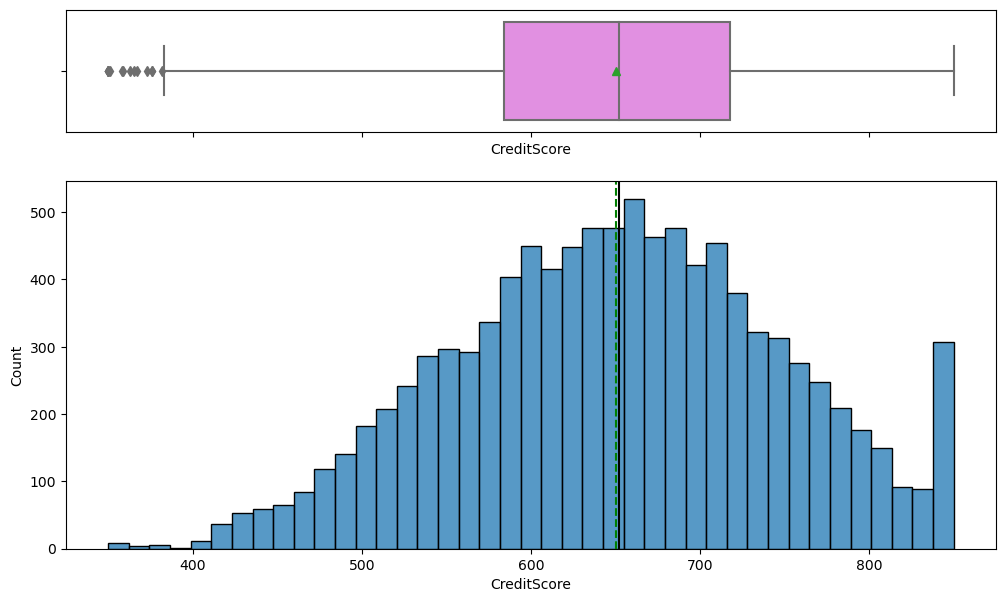

In [26]:
histogram_boxplot(data, 'CreditScore')

In [27]:
px.box(data, x='CreditScore')

#### `CreditScore` observations:

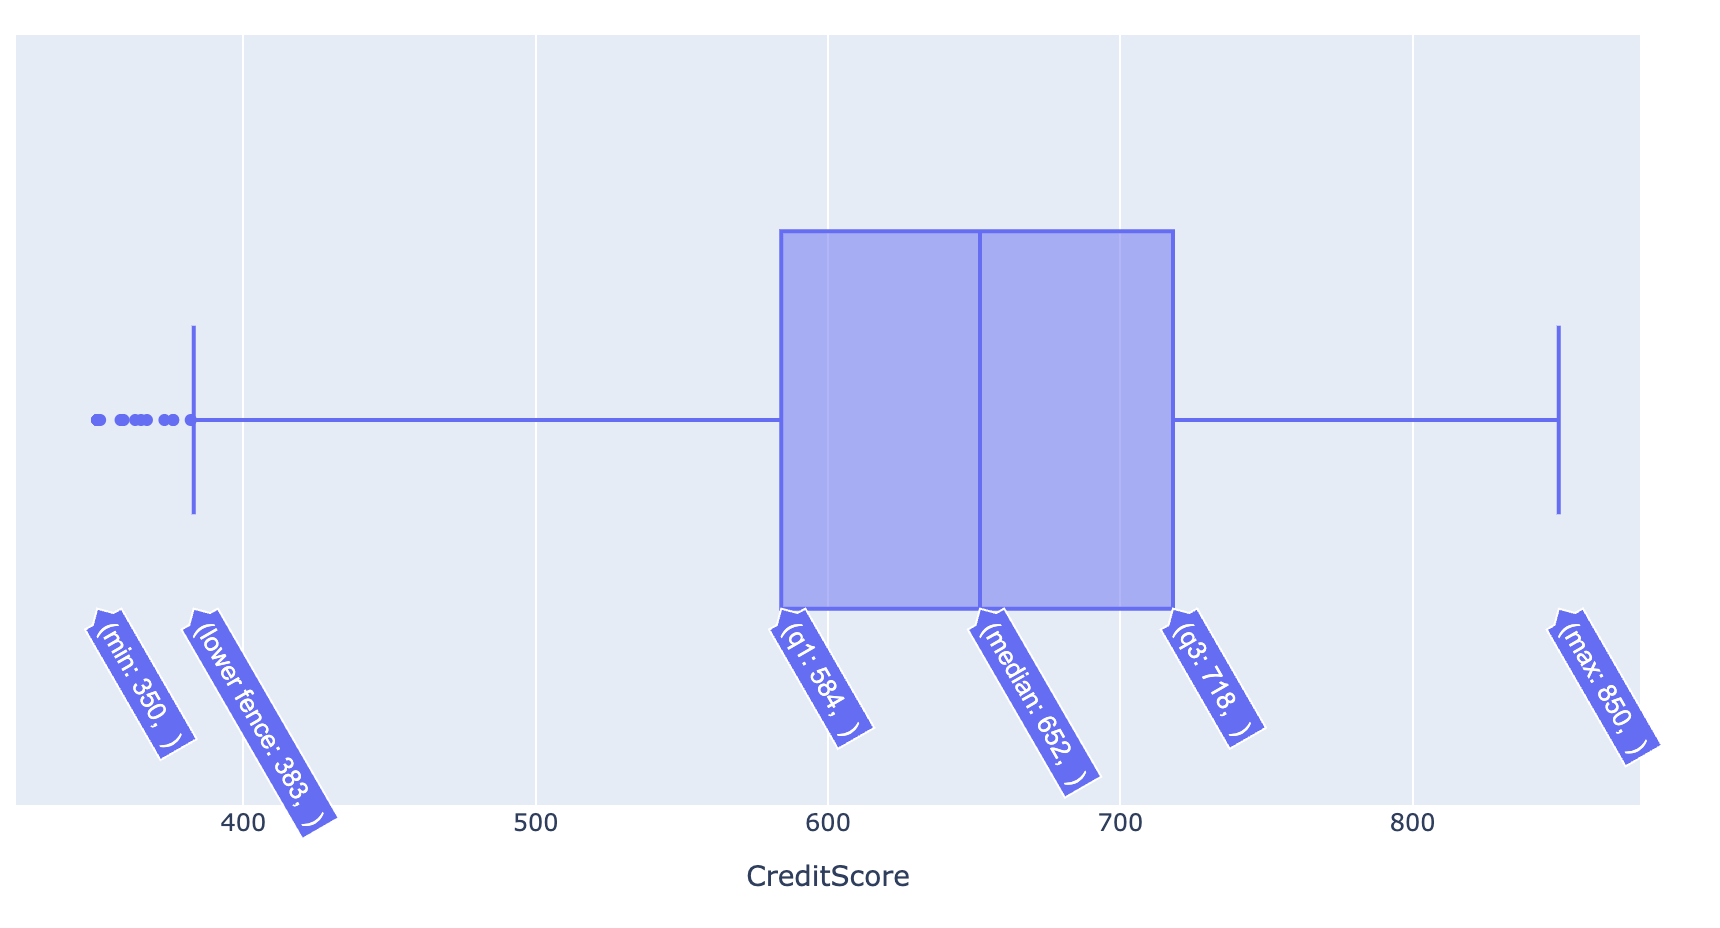

- Median `652` with a max of `850`.
- Minimum score is `350`
- Credit Scores are left-skewed.
- Outliers are very low.  Based on the `Geography`, this may be acceptable for some customers.
- Keep outliers for now.


### `Geography` Univariate Analysis

**Data dictionary definition:**

```
Geography: A customer’s location
```

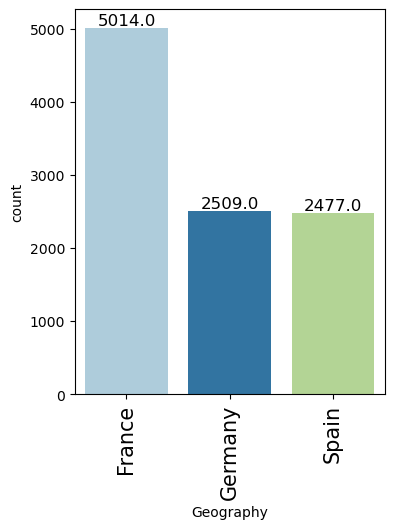

In [28]:
labeled_barplot(data, 'Geography')

#### `Geography` observations:

- About half the customers are in `France`.
- `Germany` and `Spain` split the remaining customers.

### `Age` Univariate Analysis

**Data Dictionary definition:**

```
Age: Age of the customer
```

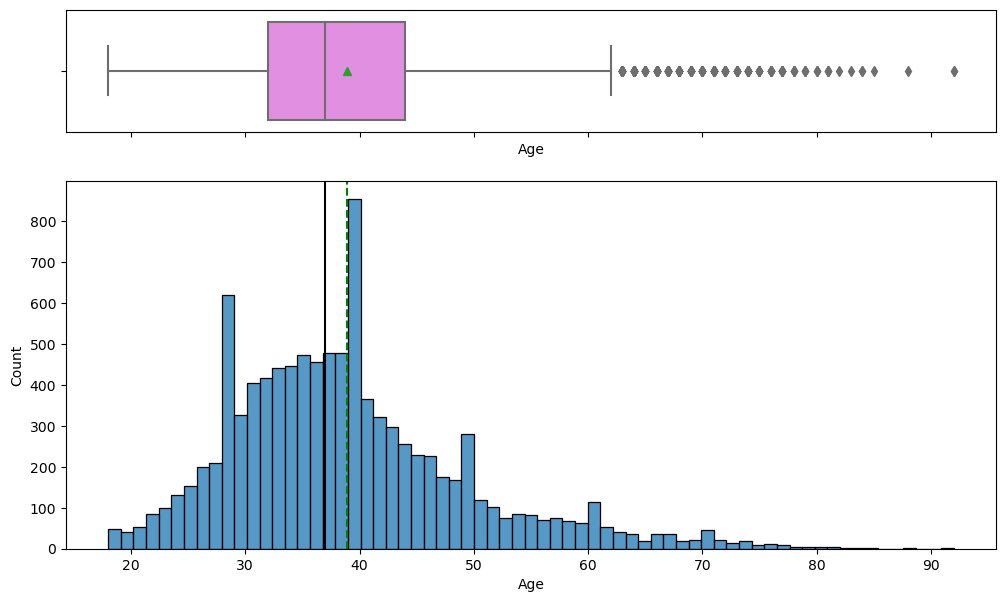

In [29]:
histogram_boxplot(data, 'Age')

In [30]:
px.box(data, x='Age')

#### `Age` observations:

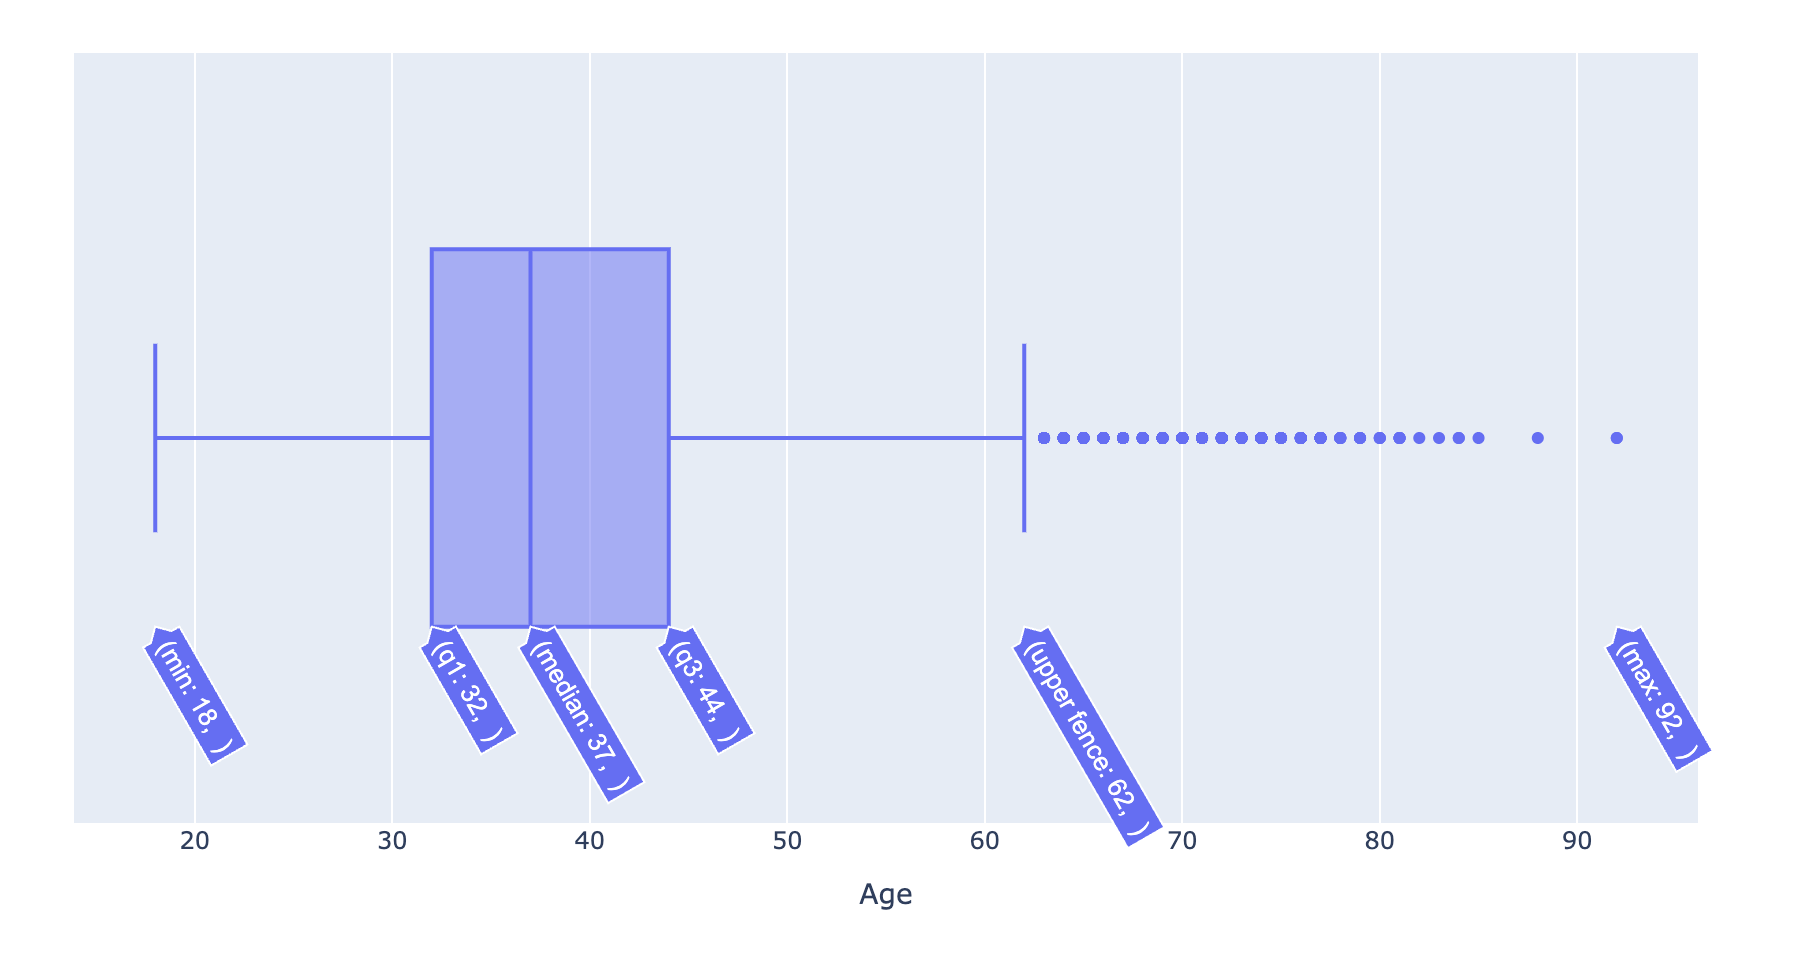

- Median `Age` is _37_.
- Minimum `Age` is _18_.
- Maximum `Age` is _92_.
- The column is right-skewed toward the maximum.
- The column contains outliers, which represent older customers.
- It is reasonable that customers may be older and outside the column distribution.

### `Tenure` Univariate Analysis

**Data Dictionary definition:**

```
Tenure: Number of years for which the customer has been with the bank
```


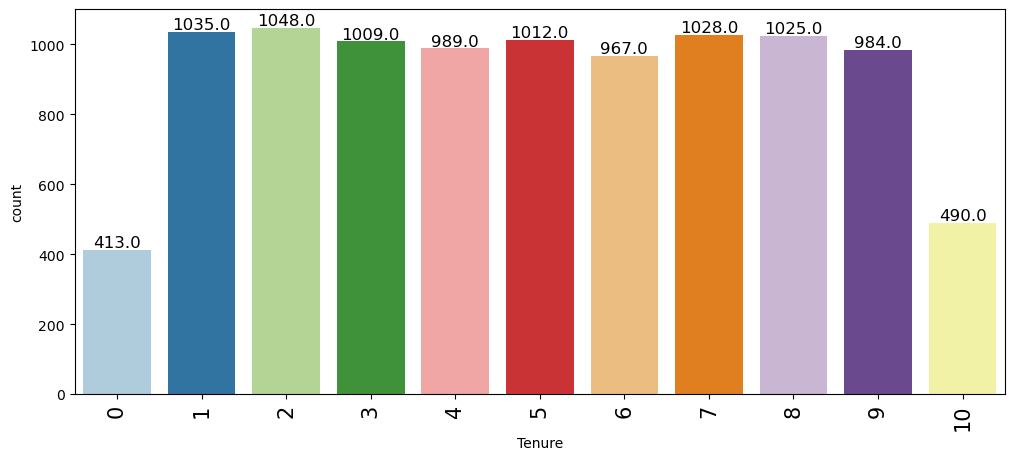

In [31]:
labeled_barplot(data, 'Tenure')

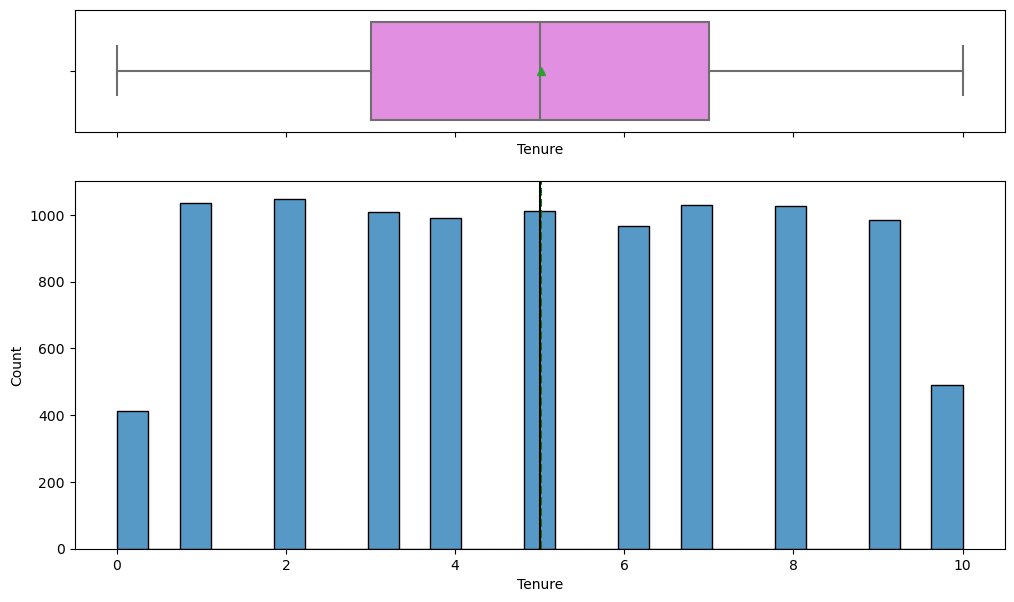

In [32]:
histogram_boxplot(data, 'Tenure')

In [33]:
px.box(data, 'Tenure')

#### `Tenure` observations:

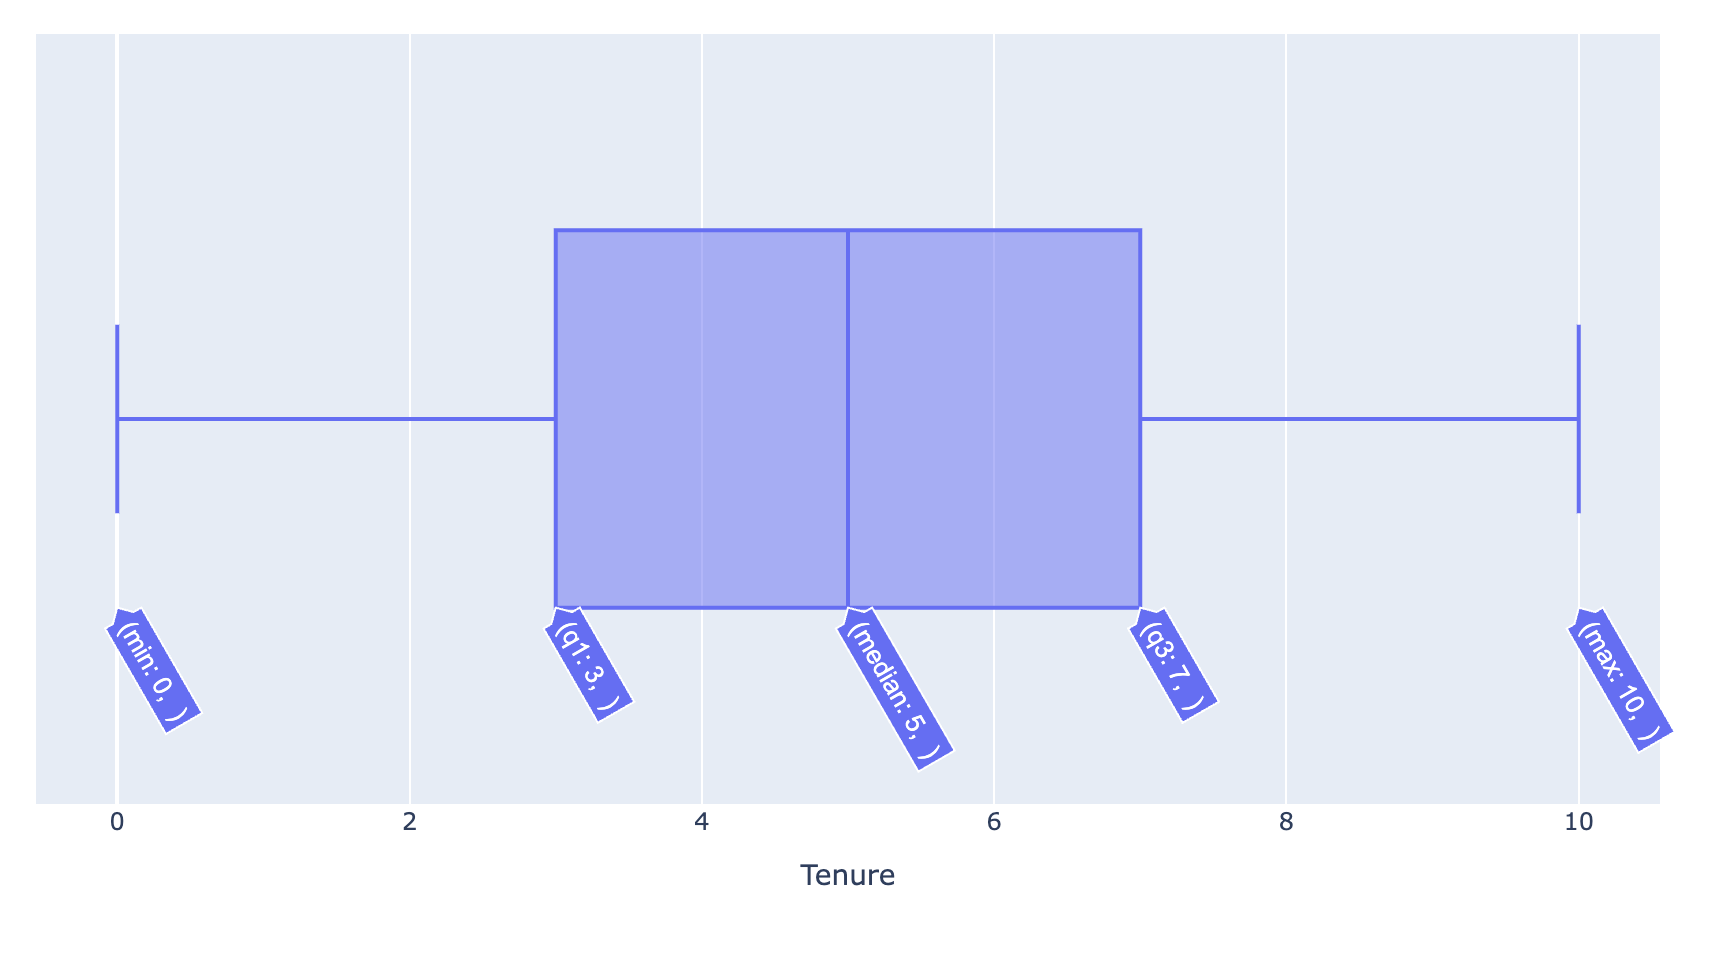

- Median `Tenure` is _5_ years as a customer with the bank.
- Maximum `Tenure` is _10_ years as a customer with the bank.
- A majority of the customers have been with the bank _1_ to _9_ years.

### `Balance` Univariate Analysis

**Data Dictionary definition:**

```
Balance: Account balance
```

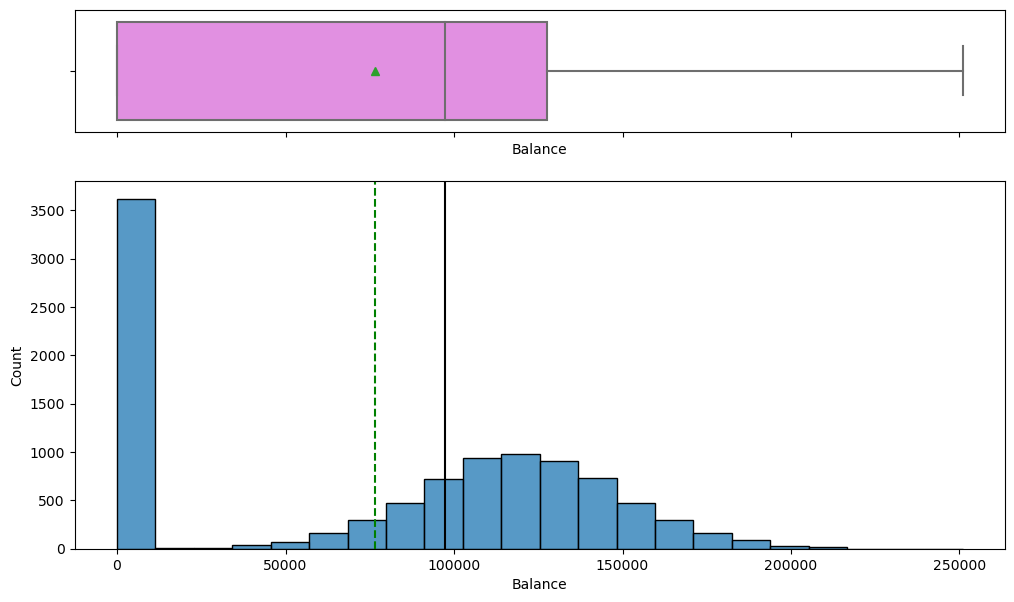

In [34]:
histogram_boxplot(data, 'Balance')

In [35]:
px.box(data, 'Balance')

#### `Balance` observations:

- A majority at _3500_ customers have _0_ balance.
- Median `Balance` is _97K_.
- Maximum `Balance` is about _251K_.
- Outside of the customers with _0_, `Balance` has a normal distribution.

### `NumOfProducts` Univariate Analysis

**Data Dictionary definition:**:

```
NumOfProducts: refers to the number of products that a customer has purchased through the bank.
```

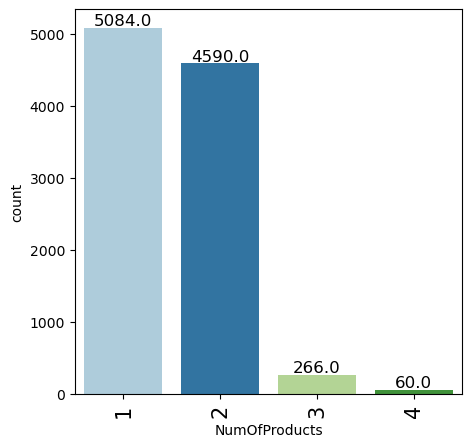

In [36]:
labeled_barplot(data, 'NumOfProducts')

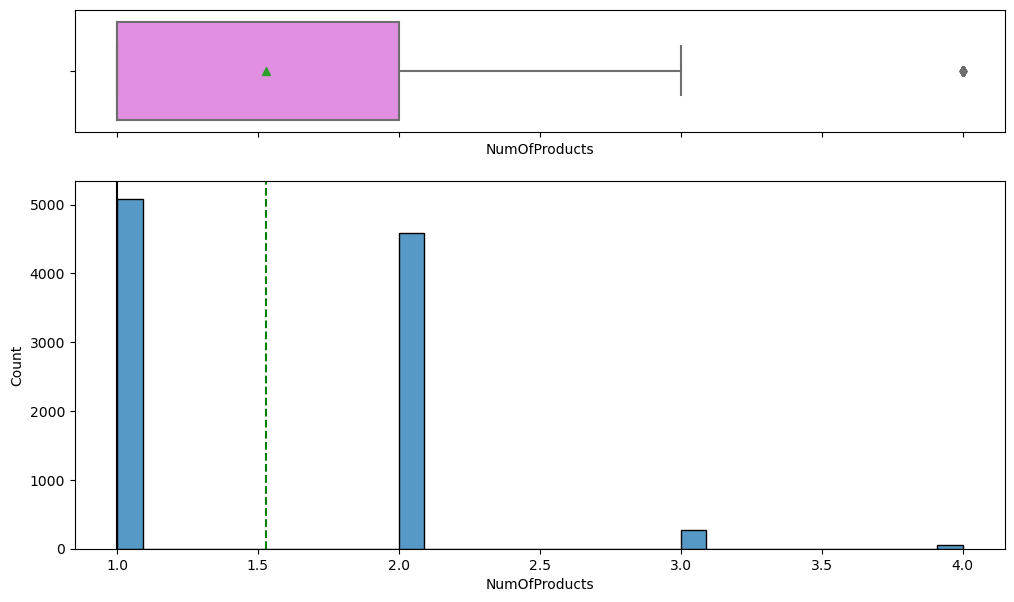

In [37]:
histogram_boxplot(data, 'NumOfProducts')

In [38]:
px.box(data, 'NumOfProducts')

#### `NumOfProducts` observations:

- Median is _1_ bank product purchased by a customer.
- Maximum is _4_ bank products purchased by a customer.
- A majority of _5084_ customers purchased a single product.  Followed by _4590_ customers purchased two products from the bank.
- _96.74 percent_ of the customers purchased 1-2 products from the bank.

### `HasCrCard` Univariate Analysis

**Data Dictionary definition:**

```
HasCrCard: It is a categorical variable which decides whether the customer has credit card or not.
```

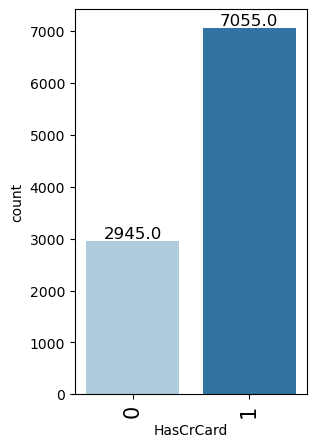

In [39]:
labeled_barplot(data, 'HasCrCard')

#### `HasCrCard` observations:

- `HasCrCard` is a boolean categorical feature.
- True (1) has a credit card: _7055_ customers.
- False (0) does not have a credit card: _2945_ customers.

### `IsActiveMember` Univariate Analysis

**Data Dictionary definition:**

```
isActiveMember: Is is a categorical variable which decides whether the customer is active member of the bank or not ( Active member in the sense, using bank products regularly, making transactions etc )
```

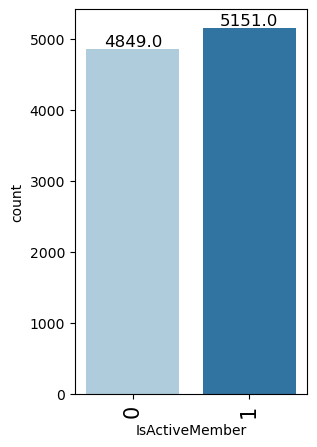

In [40]:
labeled_barplot(data, 'IsActiveMember')

#### `IsActiveMember` observations:

- `IsActiveMember` is a boolean categorical feature.
- True (1) are active members of the bank: _5151_ customers.
- False (0) are not active members of the bank: _4849_ customers.

### `EstimatedSalary` Univariate Analysis

**Data Dictionary definition:**

```
EstimatedSalary: Estimated salary
```

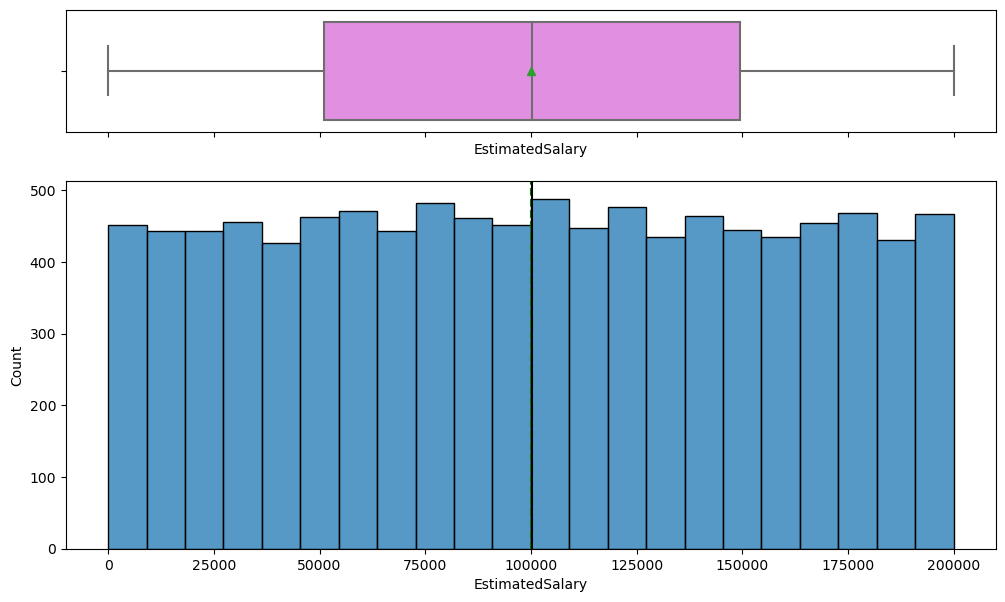

In [41]:
histogram_boxplot(data, 'EstimatedSalary')

In [42]:
px.box(data, 'EstimatedSalary')

#### `EstimatedSalary` observations:

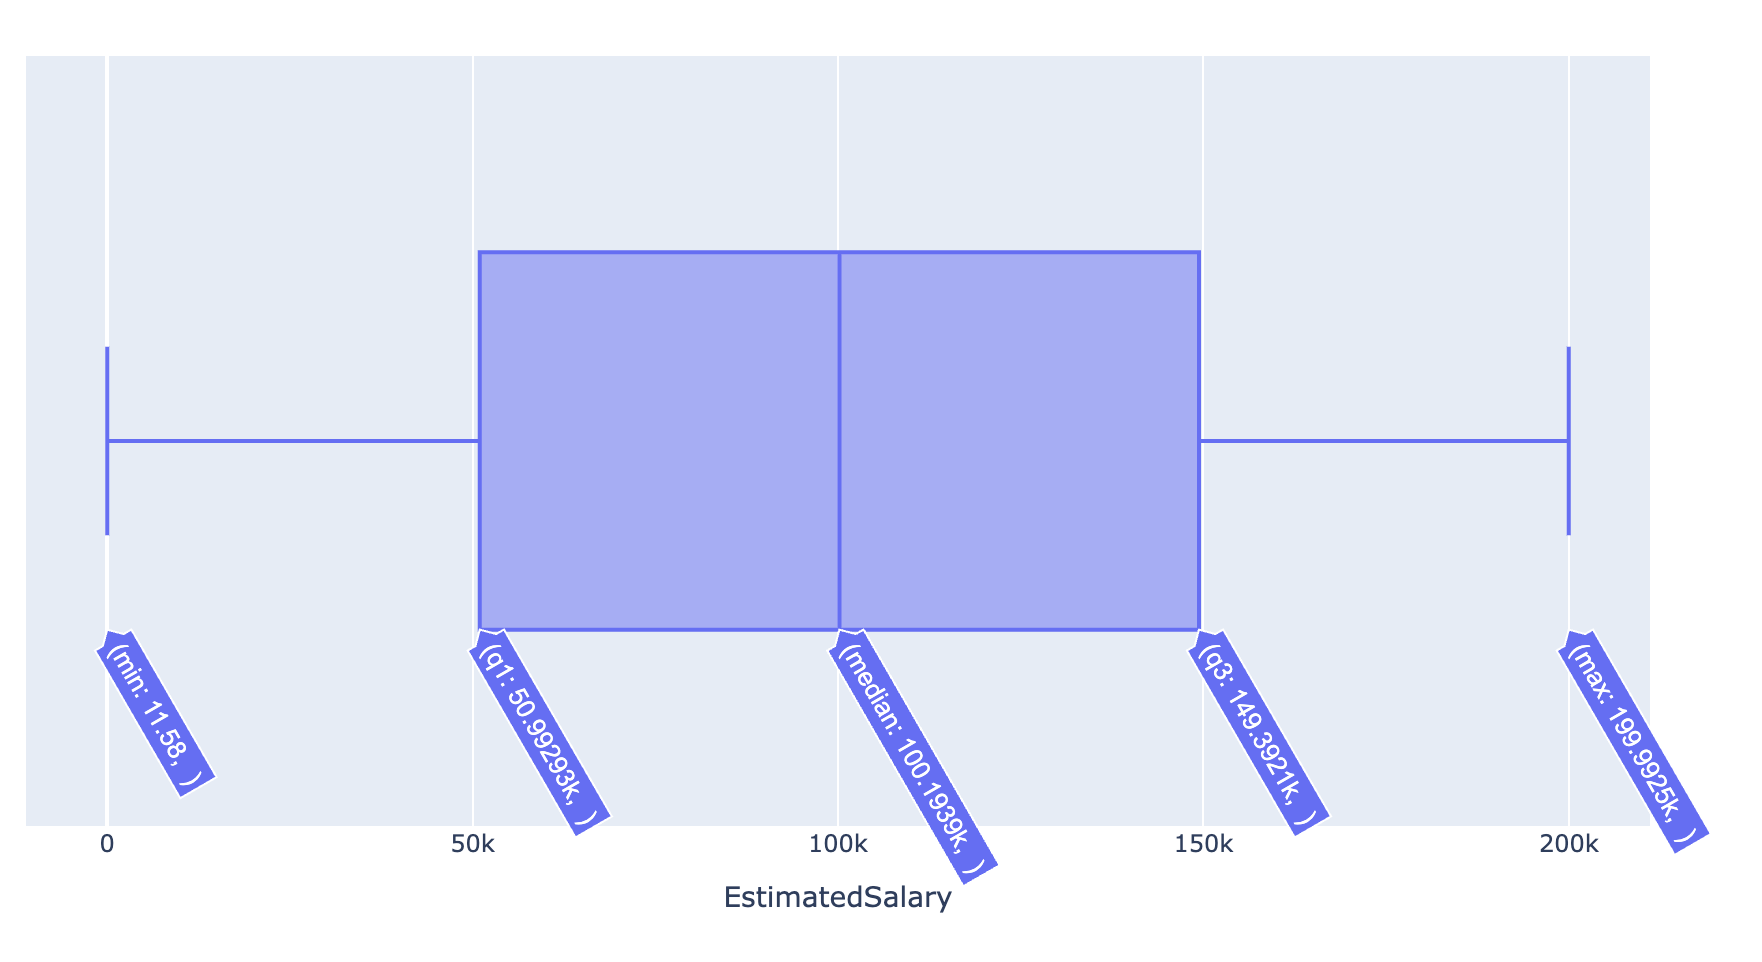

- Median `EstimatedSalary` is _100k_.
- Minimum is _11.58k_.
- Maximum is _200k_.


### `Exited` Univariate Analysis

**Data Dictionary definition:**

```
Exited : whether or not the customer left the bank within six month. It can take two values 
** 0=No ( Customer did not leave the bank )
** 1=Yes ( Customer left the bank )
```

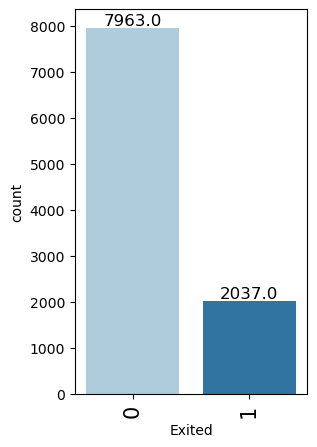

In [43]:
labeled_barplot(data, 'Exited')

#### `Exited` observations:

- `Exited` is a boolean classification target.
- False (0) have not left the bank within six months: _7963_ customers.
- True (1) have left the bank within six months: _2037_ customers.
- The target value is imbalanced favoring False.  I will try different techniques to balance `Exited` for model training.

---

### Bivariate Analysis

- First, generate a heatmap and pairplot of the data.


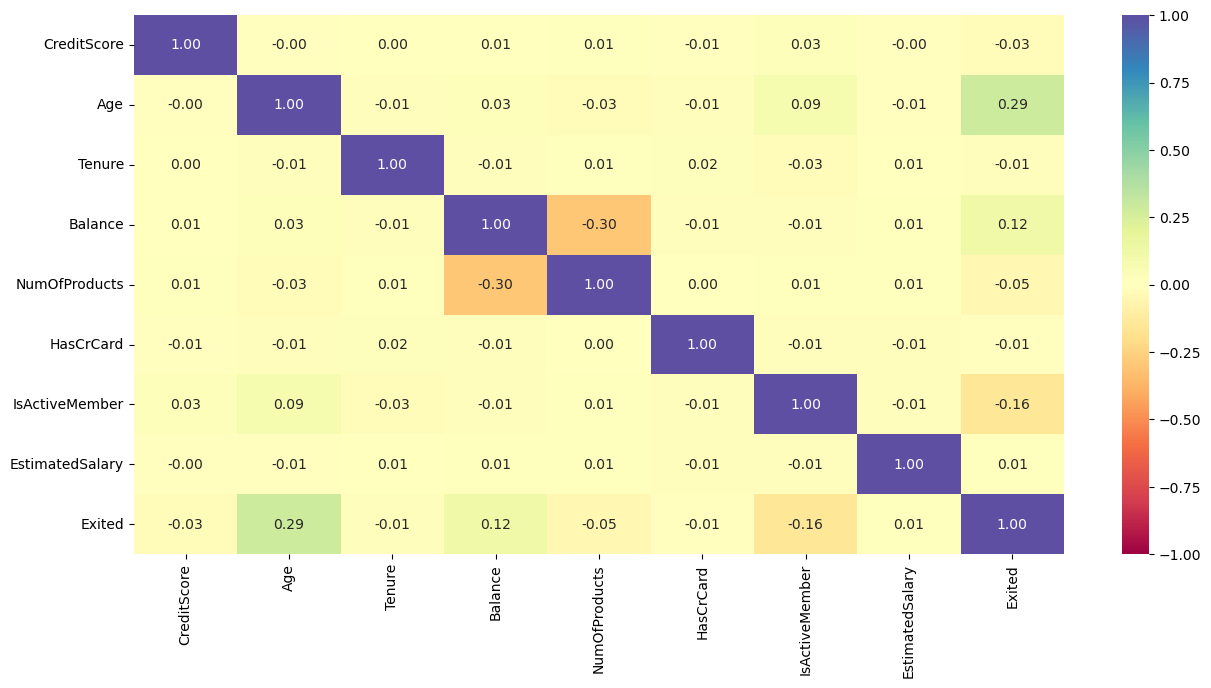

In [44]:
plt.figure(figsize=(15, 7))
sns.heatmap(data.corr(numeric_only=True), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

#### Heatmap observations

**Positive correlations:**

- There is no high correlation of any of the features.
- There is a correlation of _0.29_ between `Age` and `Exited`.
- There is a small correlation of _0.12_ between `Balance` and `Exited`.
- There is a small correlation of _0.09_ between `Age` and `IsActiveMember`.

**Negative correlations:**

- There is a negative correlation between `NumOfProducts` and `Balance`.
- There is a slight negative correlation between `IsActiveMember` and `Exited`.
- There is a slight negative correlation between `NumOfProducts` and `Exited`.

### Pair Plot

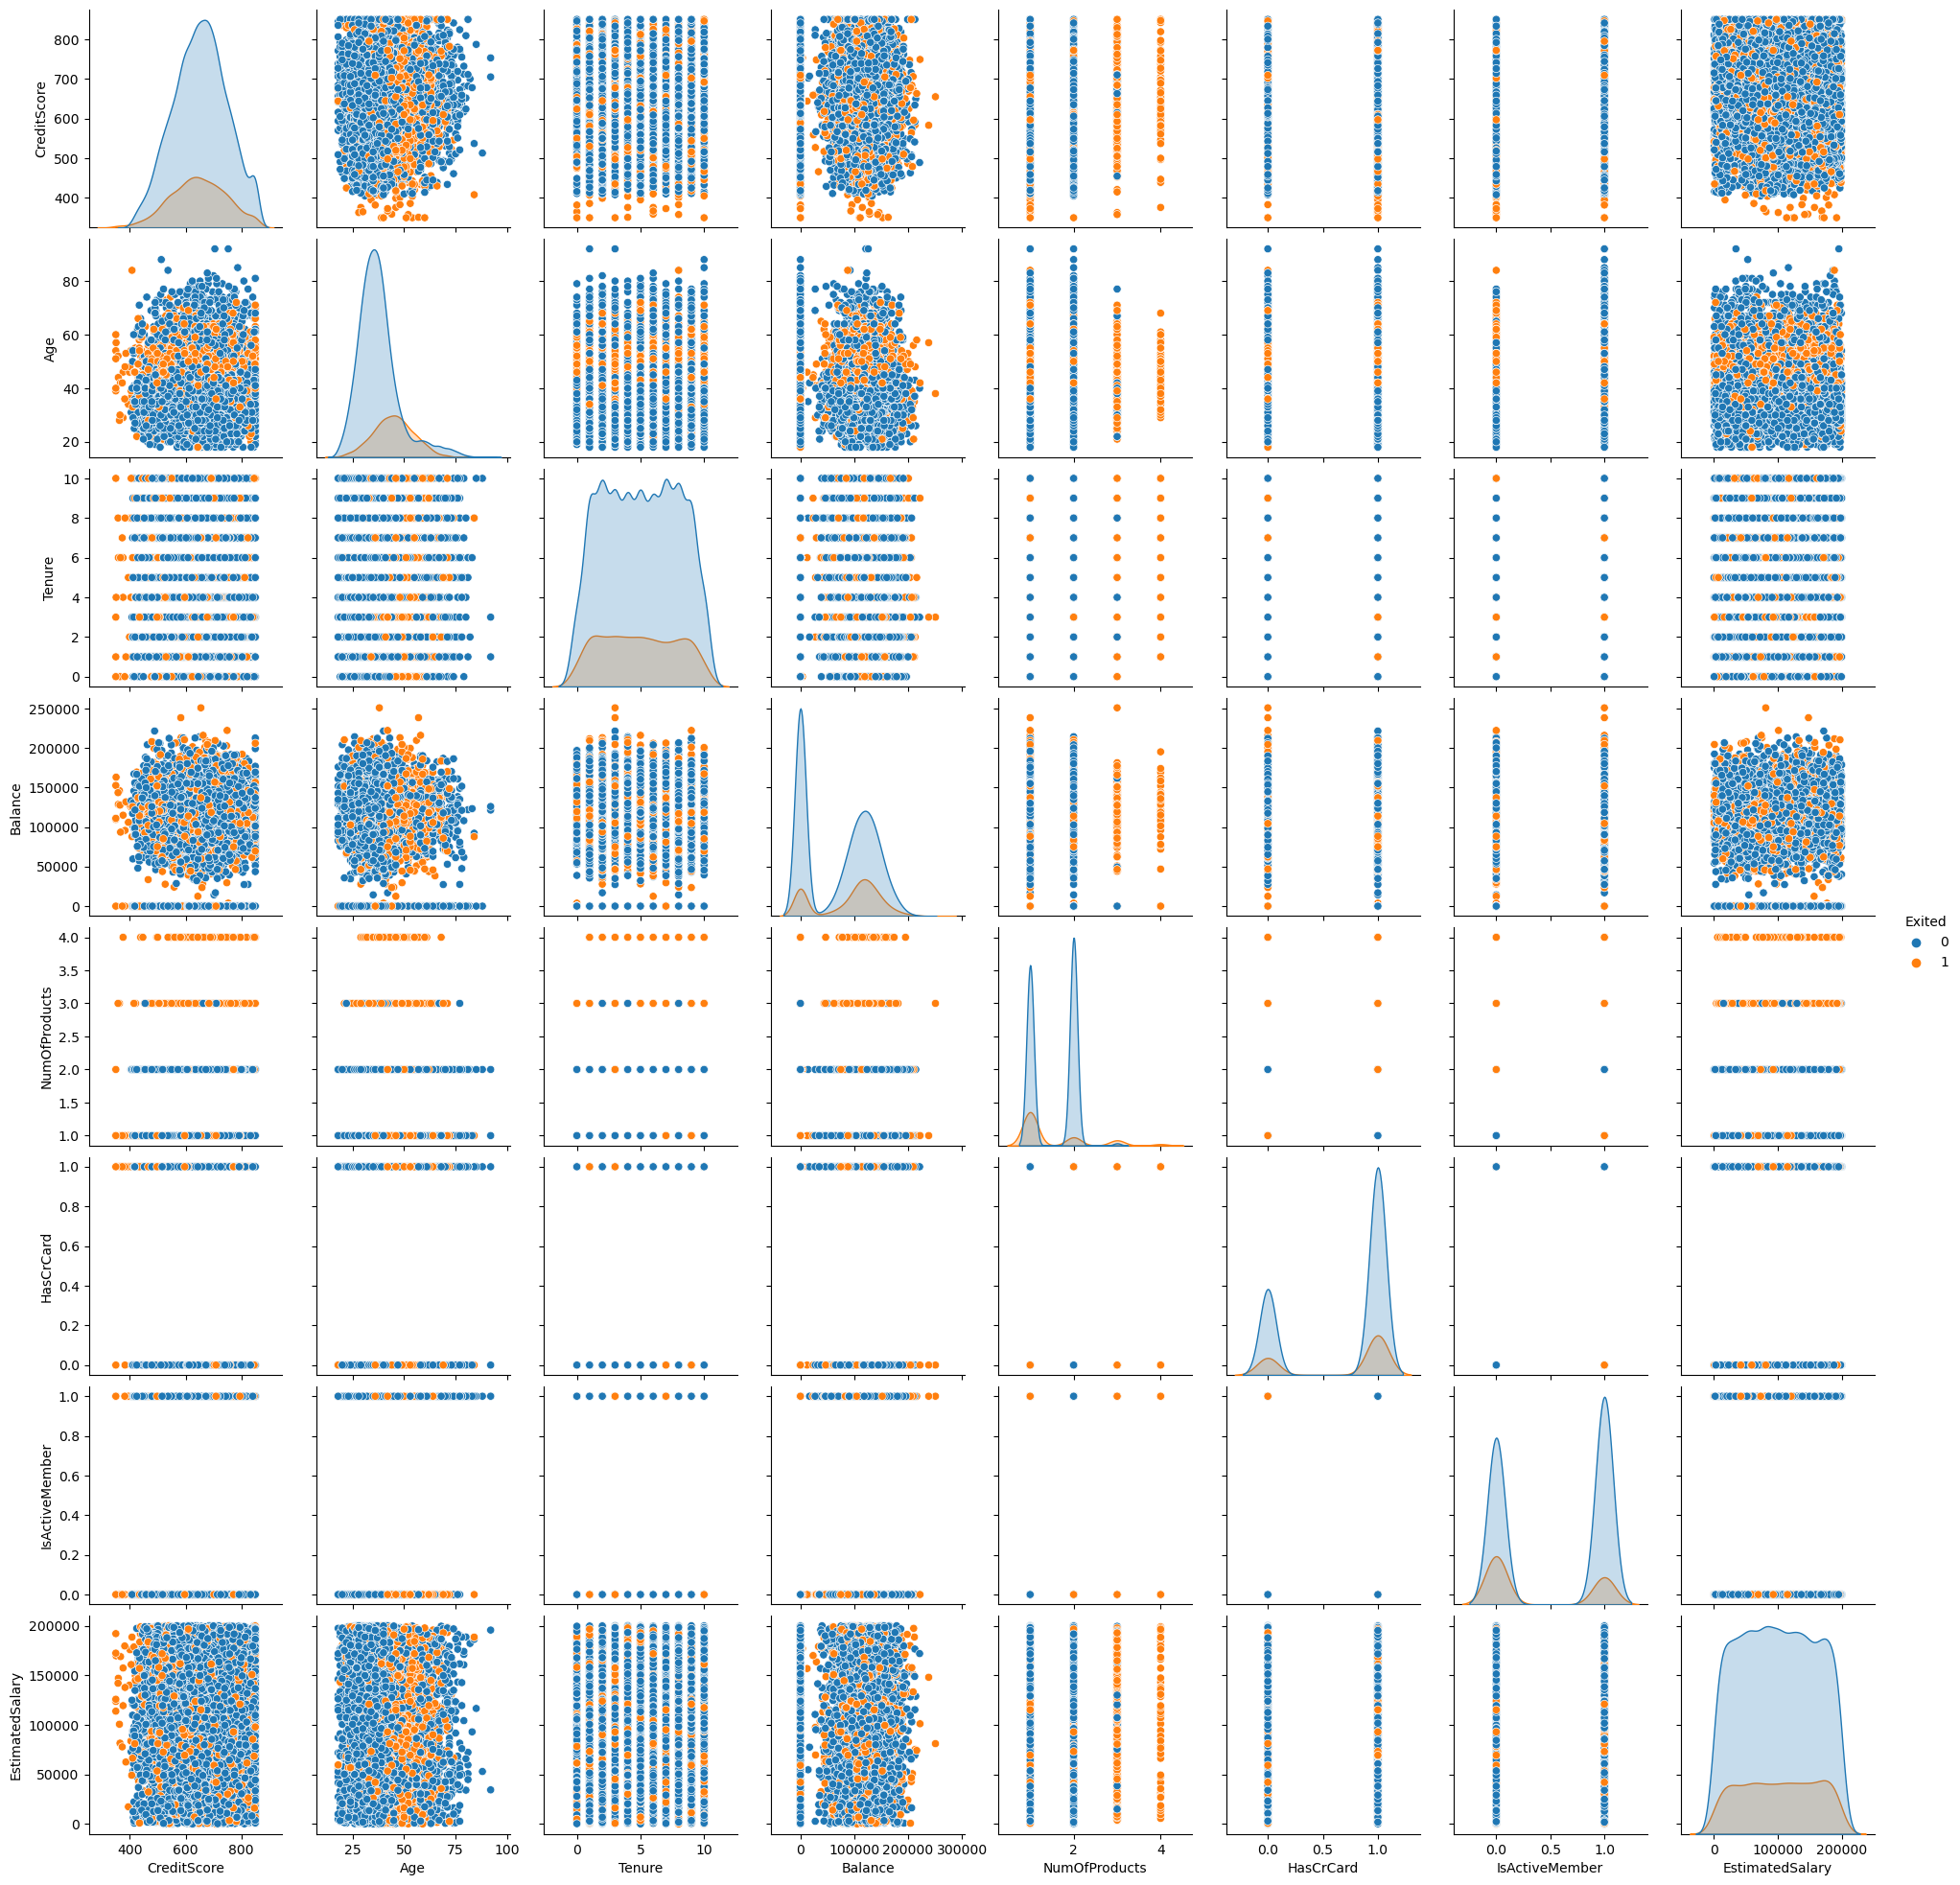

In [45]:
sns.pairplot(data=data, diag_kind="kde", hue='Exited')
plt.show()

#### Pair Plot observations:

- There appears to be a slight relationship between `Age` and `CreditScore`.
- There appears to be a slight relationship between `Balance` and `Age`.
- There appears to be a slight relationship between `EstimatedSalary` and `Age`.
- There appears to be higher `Exited` for 3 or more `NumOfProducts` with a relationship among `Age`, `Balance`, and `Tenure`.

### `CreditScore` with `Exited`


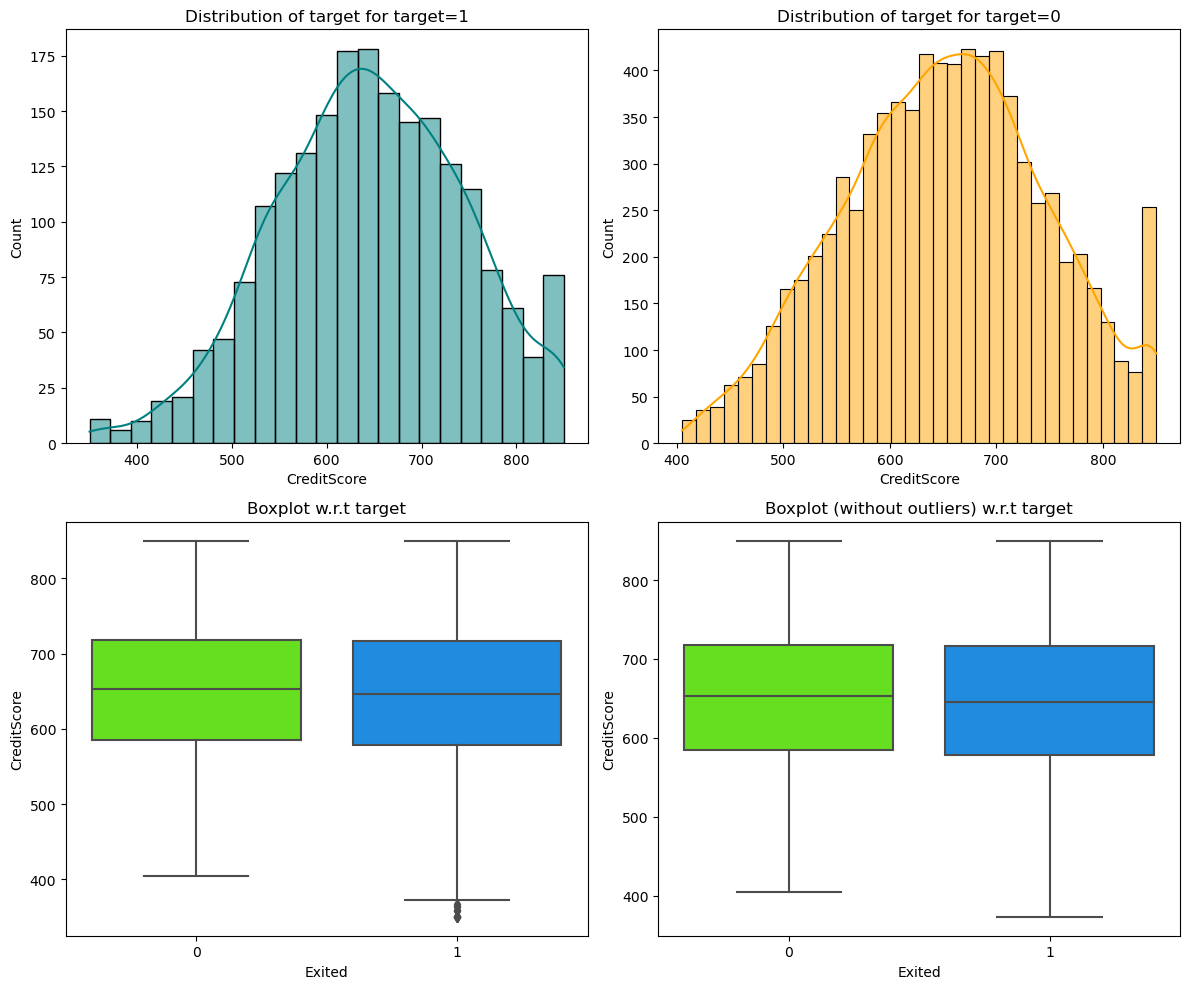

In [46]:
distribution_plot_wrt_target(data, 'CreditScore', 'Exited')

#### `CreditScore` with `Exited` observations:

- Both plots are similar.
- No obvious differences.

### `Geography` with `Exited`

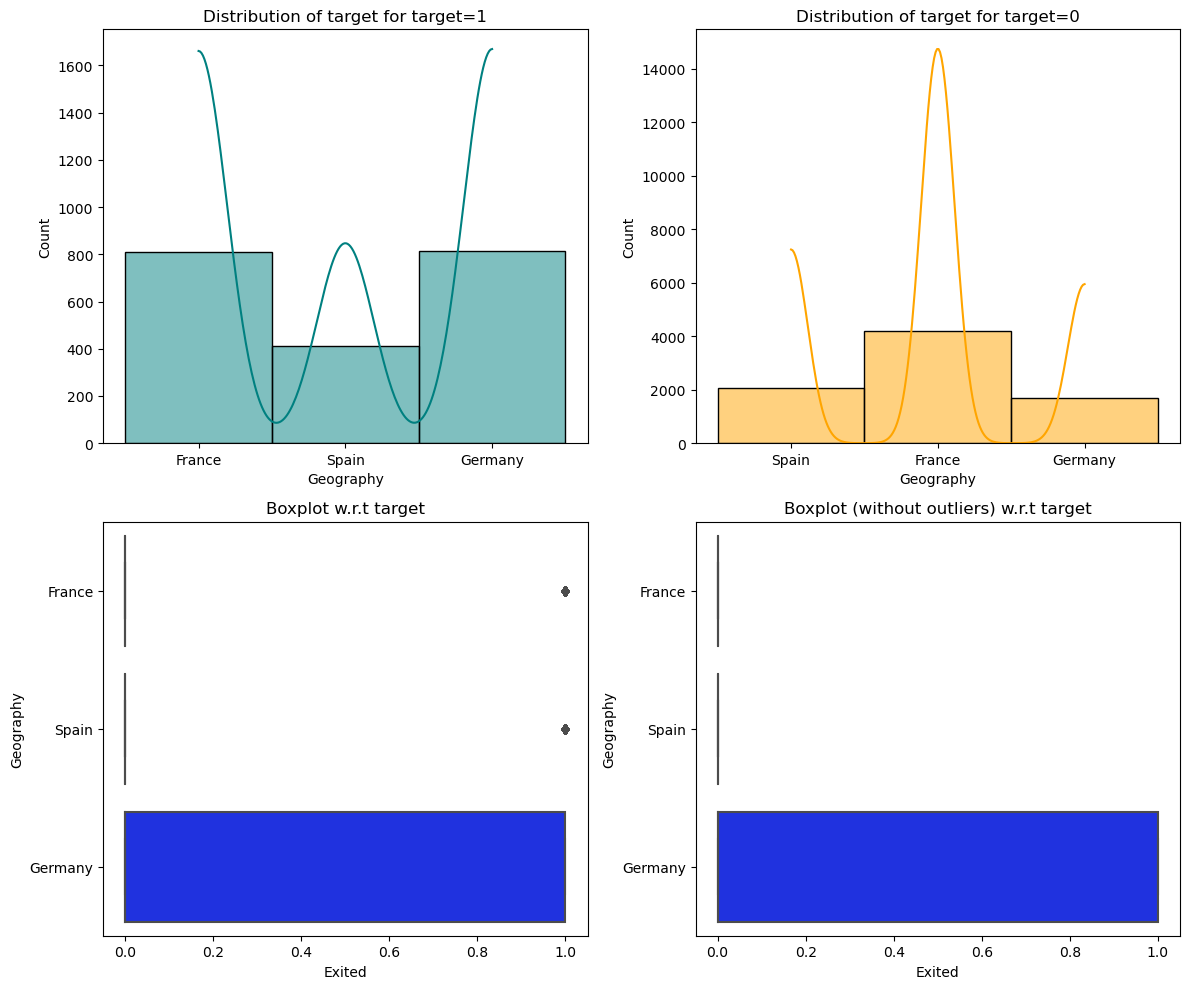

In [47]:
distribution_plot_wrt_target(data, 'Geography', 'Exited')

Exited        0     1    All
Geography                   
All        7963  2037  10000
Germany    1695   814   2509
France     4204   810   5014
Spain      2064   413   2477
------------------------------------------------------------------------------------------------------------------------


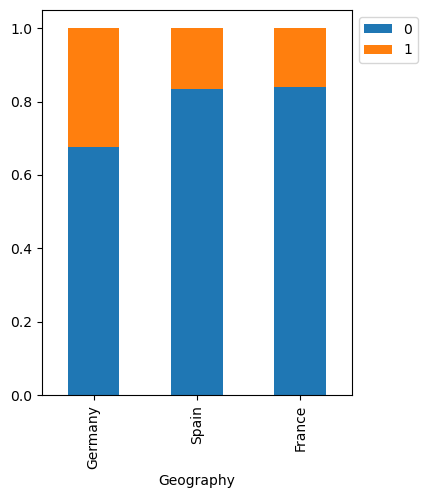

In [48]:
stacked_barplot(data, 'Geography', 'Exited')

#### `Geography` with `Exited` observations:

- Percentage-wise, _32.6 percent_ customers `Exited` from Germany which is the most per region.
- Percentage-wise, Spain and France had similar `Exited` customers at about _16 percent_.

### `Gender` with `Exited`

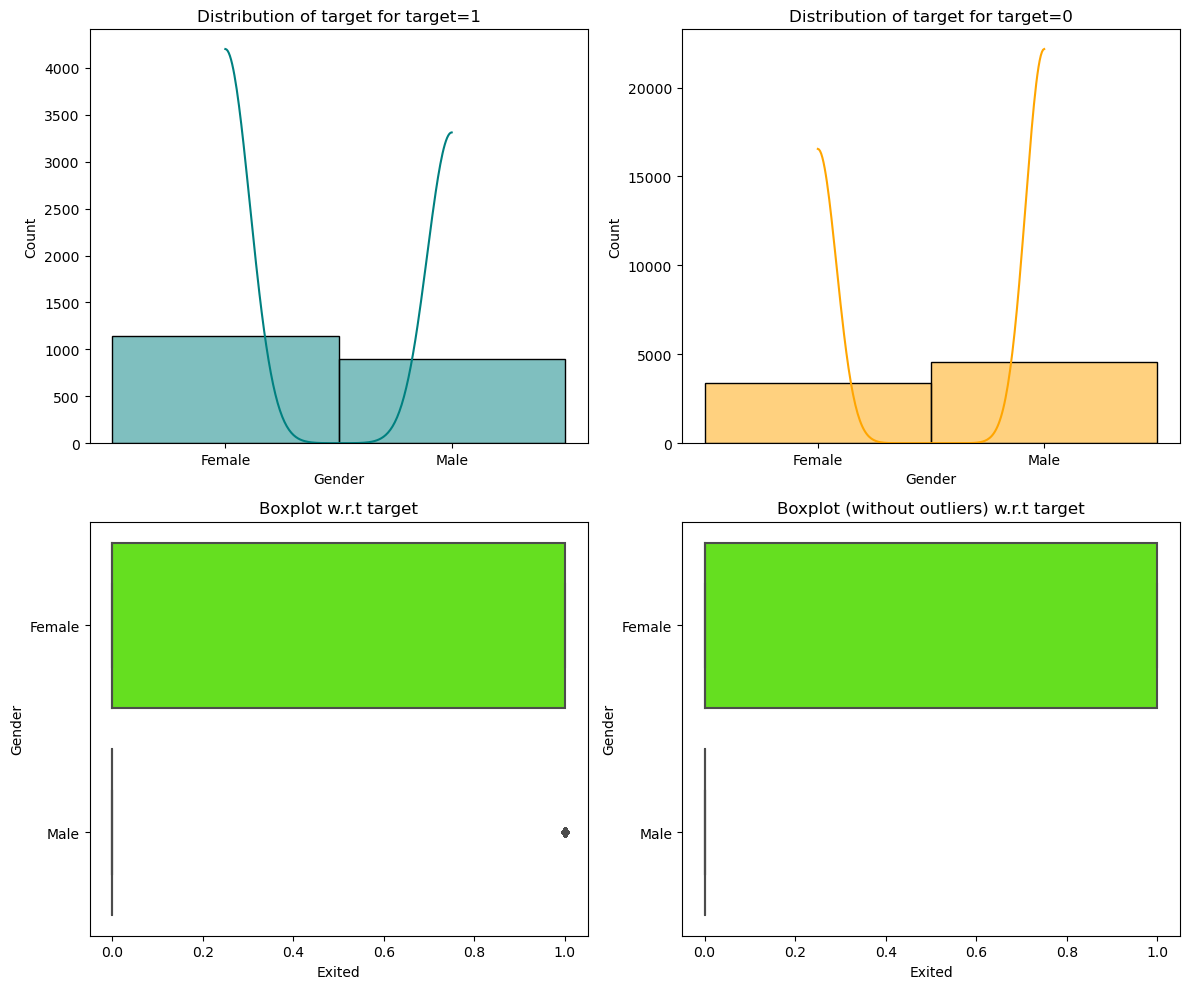

In [49]:
distribution_plot_wrt_target(data, 'Gender', 'Exited')

Exited     0     1    All
Gender                   
All     7963  2037  10000
Female  3404  1139   4543
Male    4559   898   5457
------------------------------------------------------------------------------------------------------------------------


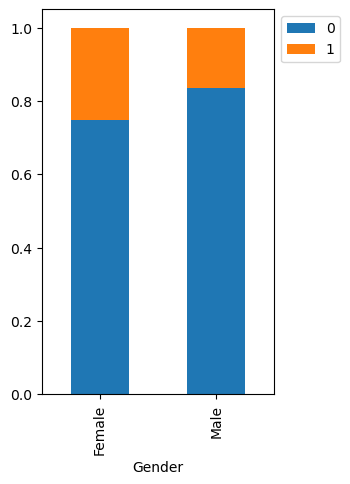

In [50]:
stacked_barplot(data, 'Gender', 'Exited')

#### `Gender` with `Exited` observations:

- _25 percent_ of Females `Exited` at _1139_ customers.
- _16.5 percent_ of Males `Exited` at _898_ customers.

### `Age` with `Exited`


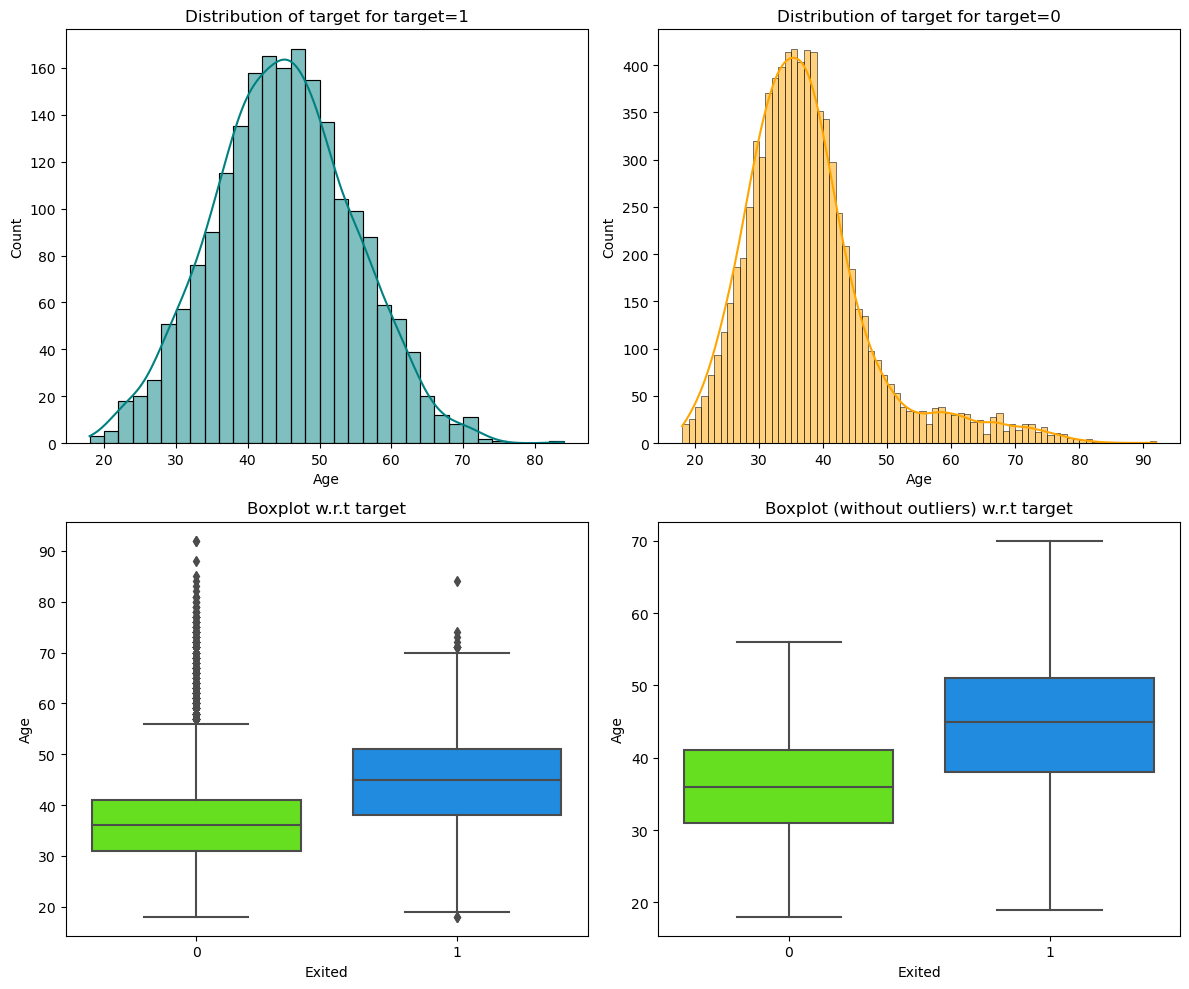

In [51]:
distribution_plot_wrt_target(data, 'Age', 'Exited')

Exited     0     1    All
Age                      
All     7963  2037  10000
46       135    91    226
40       343    89    432
43       209    88    297
45       142    87    229
48        88    80    168
47        98    77    175
42       244    77    321
49        72    75    147
44       184    73    257
39       351    72    423
50        63    71    134
41       297    69    366
51        53    66    119
52        38    64    102
38       414    63    477
37       416    62    478
35       417    57    474
36       403    53    456
54        33    51     84
56        20    50     70
55        34    48     82
33       398    44    442
53        34    40     74
57        37    38     75
34       414    33    447
31       371    33    404
32       386    32    418
60        30    32     62
59        32    30     62
58        38    29     67
29       320    28    348
30       303    24    327
28       250    23    273
62        31    21     52
61        32    21     53
63        22

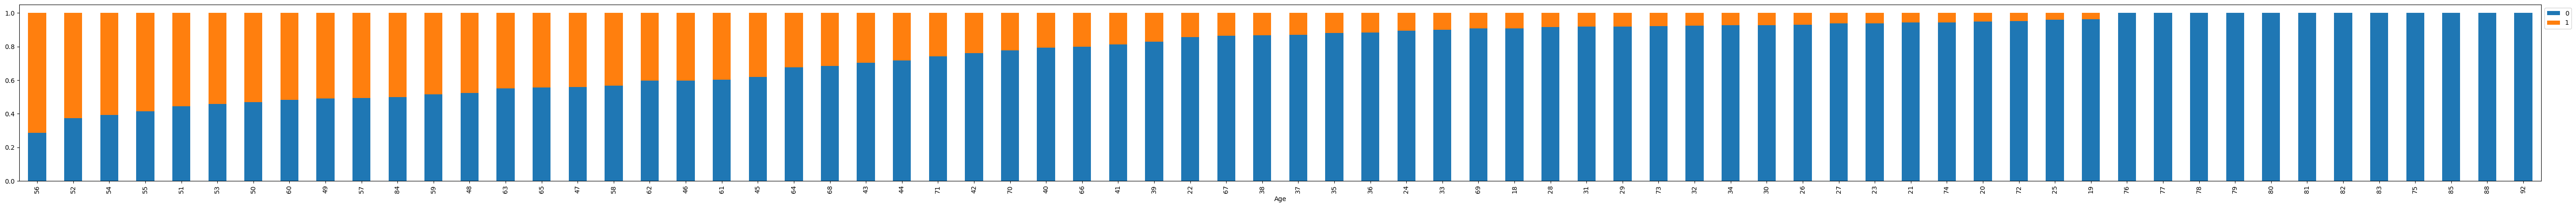

In [52]:
stacked_barplot(data, 'Age', 'Exited')

#### `Age` with `Exited`

- `Exited` customers is _True_ follows a normal distribution curve with some outliers.

### `Tenure` with `Exited`

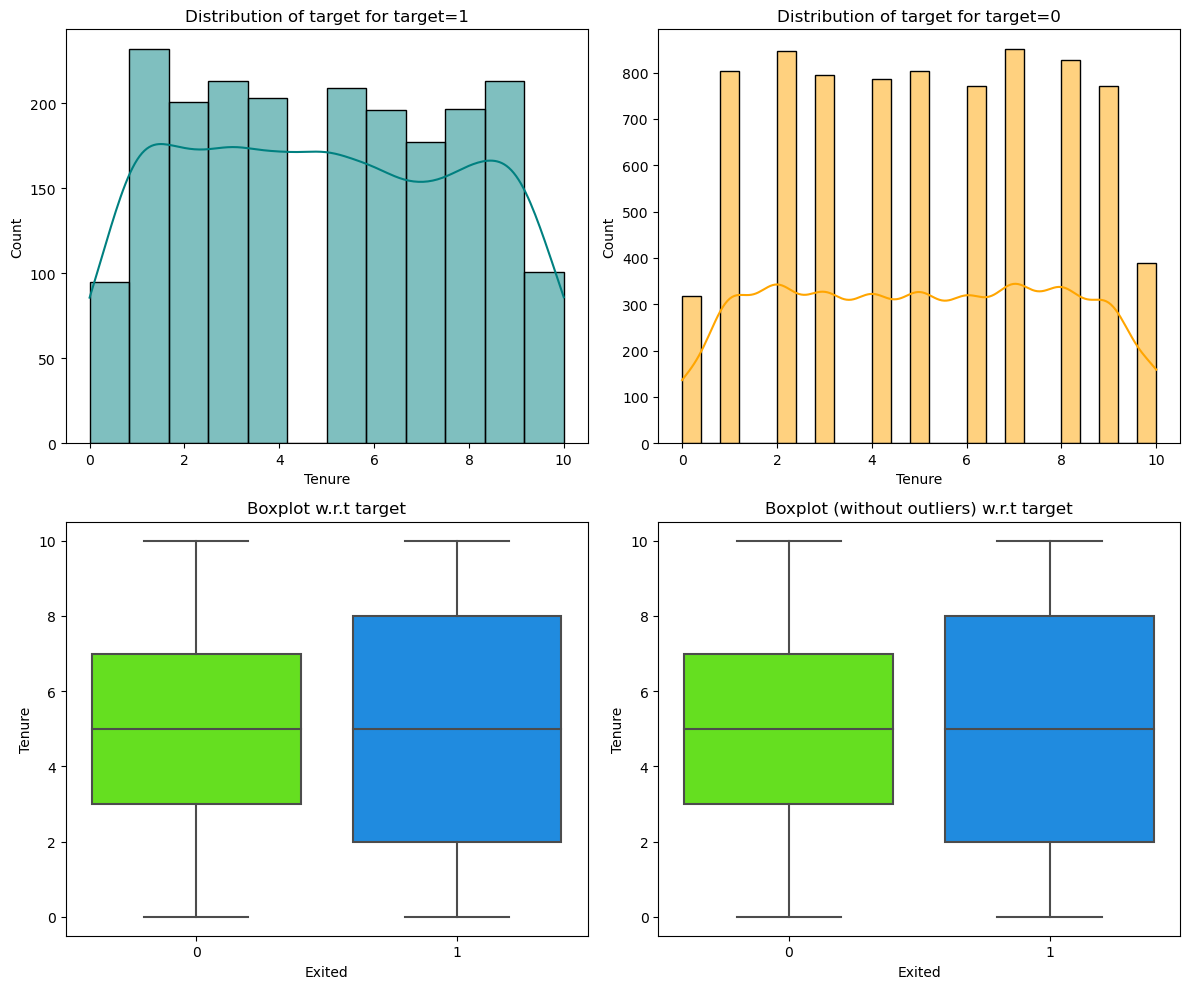

In [53]:
distribution_plot_wrt_target(data, 'Tenure', 'Exited')

Exited     0     1    All
Tenure                   
All     7963  2037  10000
1        803   232   1035
3        796   213   1009
9        771   213    984
5        803   209   1012
4        786   203    989
2        847   201   1048
8        828   197   1025
6        771   196    967
7        851   177   1028
10       389   101    490
0        318    95    413
------------------------------------------------------------------------------------------------------------------------


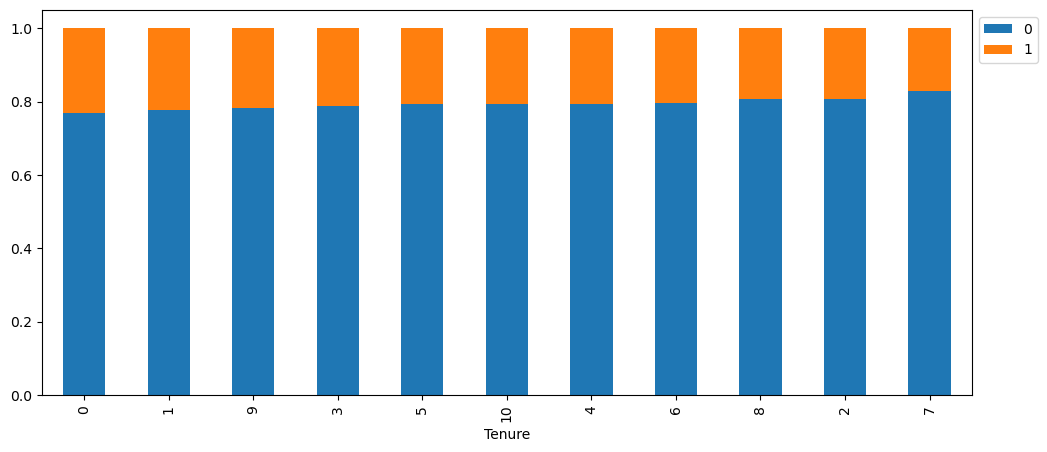

In [54]:
stacked_barplot(data, 'Tenure', 'Exited')

#### `Tenure` with `Exited`

- All year groups had `Exited` customers around _22 percent_.
- There does not appear to matter how many years `Tenure` a customer has with the bank.

### `Balance` with `Exited`

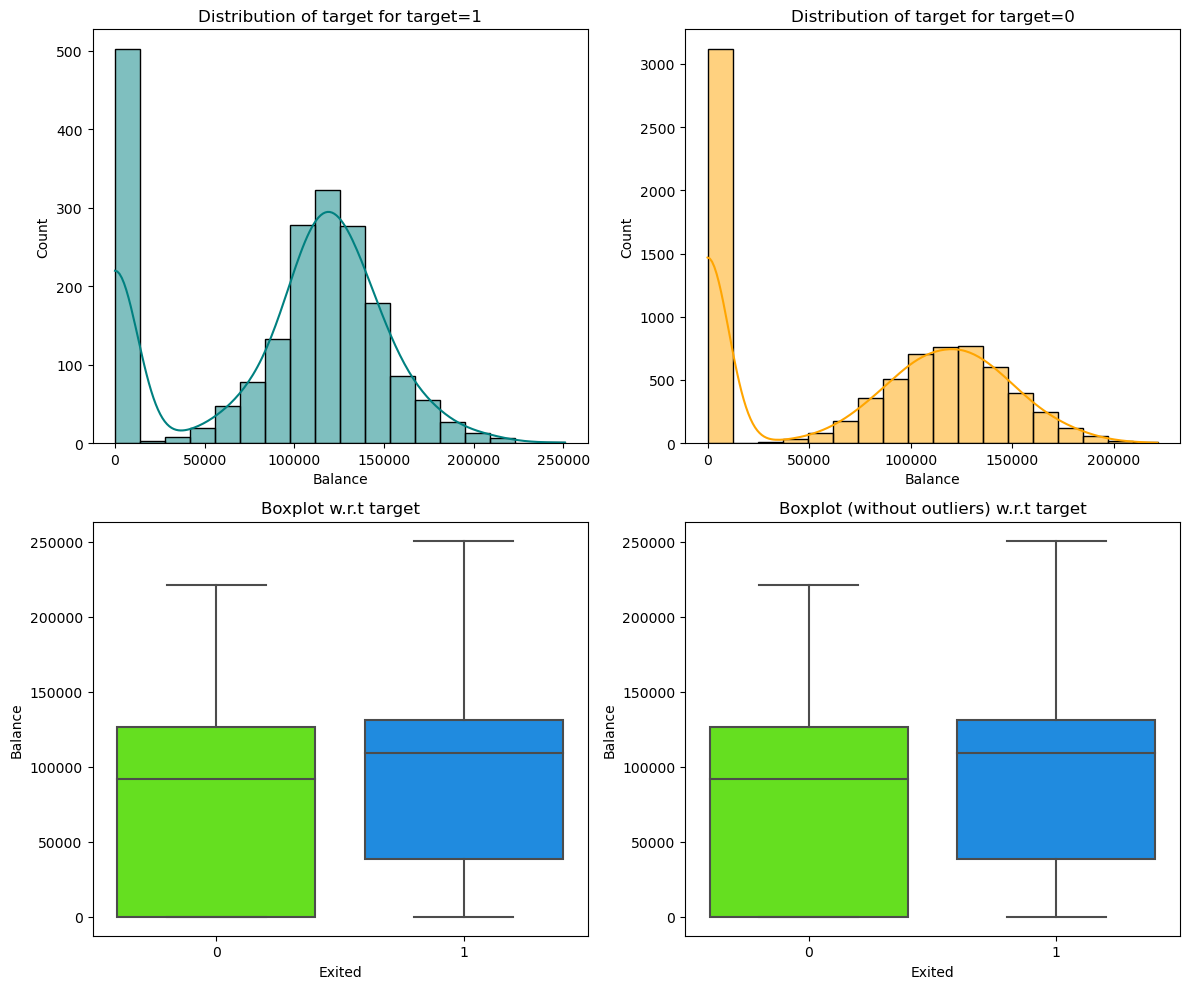

In [55]:
distribution_plot_wrt_target(data, 'Balance', 'Exited')

#### `Balance` with `Exited`

- `Exited` and not `Exited` both appear to have a normal distribution.
- `Balance` amount does not appear to be a factor based on initial assessment.

### `NumOfProducts` with `Exited`

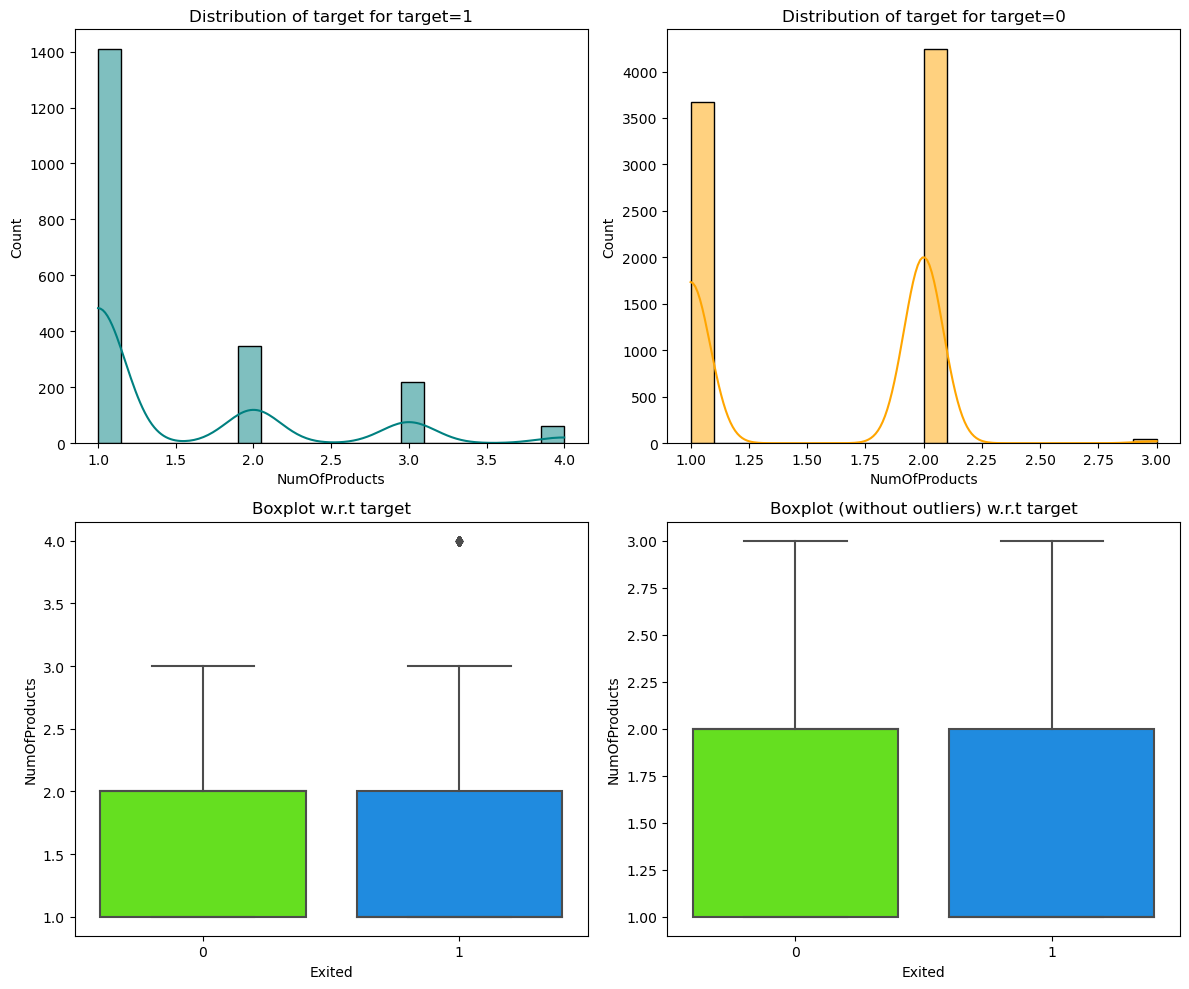

In [56]:
distribution_plot_wrt_target(data, 'NumOfProducts', 'Exited')

Exited            0     1    All
NumOfProducts                   
All            7963  2037  10000
1              3675  1409   5084
2              4242   348   4590
3                46   220    266
4                 0    60     60
------------------------------------------------------------------------------------------------------------------------


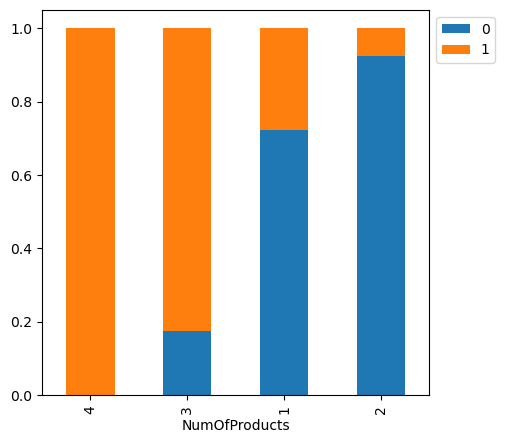

In [57]:
stacked_barplot(data, 'NumOfProducts', 'Exited')

#### `NumOfProducts` with `Exited`

- Interestingly, when a customer has more than _2_ products from the bank, they have a higher likelyhood of being an `Exited` customer.
- _4_ products has a _100 percent_ `Exited` customer rate.
- _3_ products has a _82.7 percent_ `Exited` customer rate.
- These rates are very high.

### `HasCrCard` with `Exited`

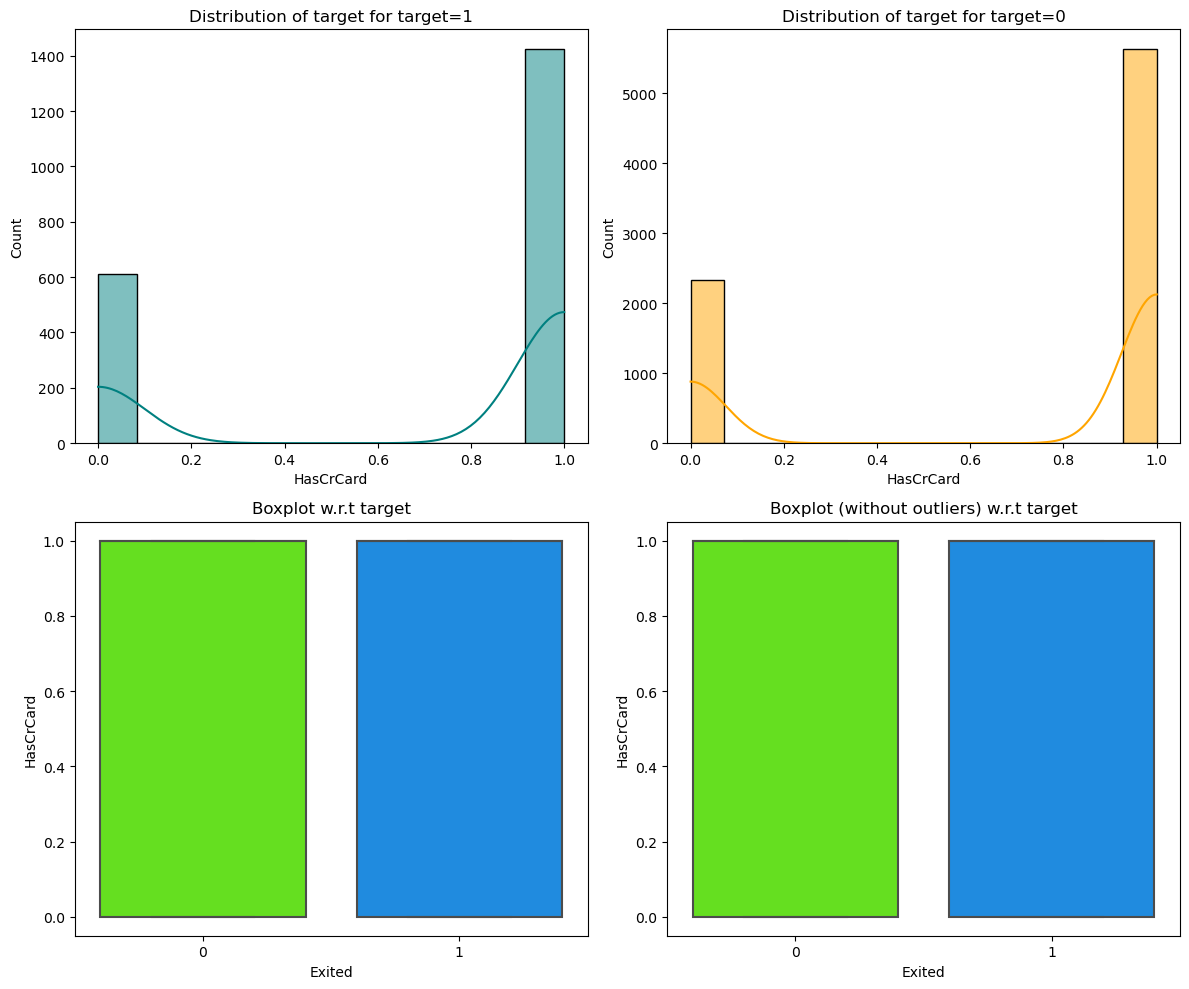

In [58]:
distribution_plot_wrt_target(data, 'HasCrCard', 'Exited')

Exited        0     1    All
HasCrCard                   
All        7963  2037  10000
1          5631  1424   7055
0          2332   613   2945
------------------------------------------------------------------------------------------------------------------------


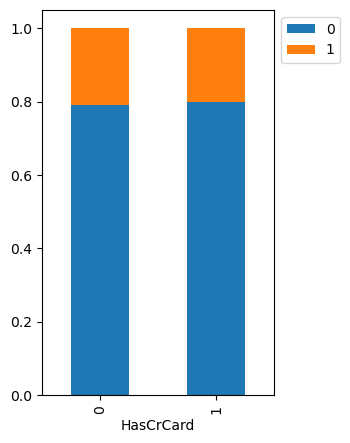

In [59]:
stacked_barplot(data, 'HasCrCard', 'Exited')

#### `HasCrCard` with `Exited`

- There does not appear to matter if a customer has a credit card with the bank.
- `Exited` rate is about the same at _20_ percent.

### `IsActiveMember` with `Exited`

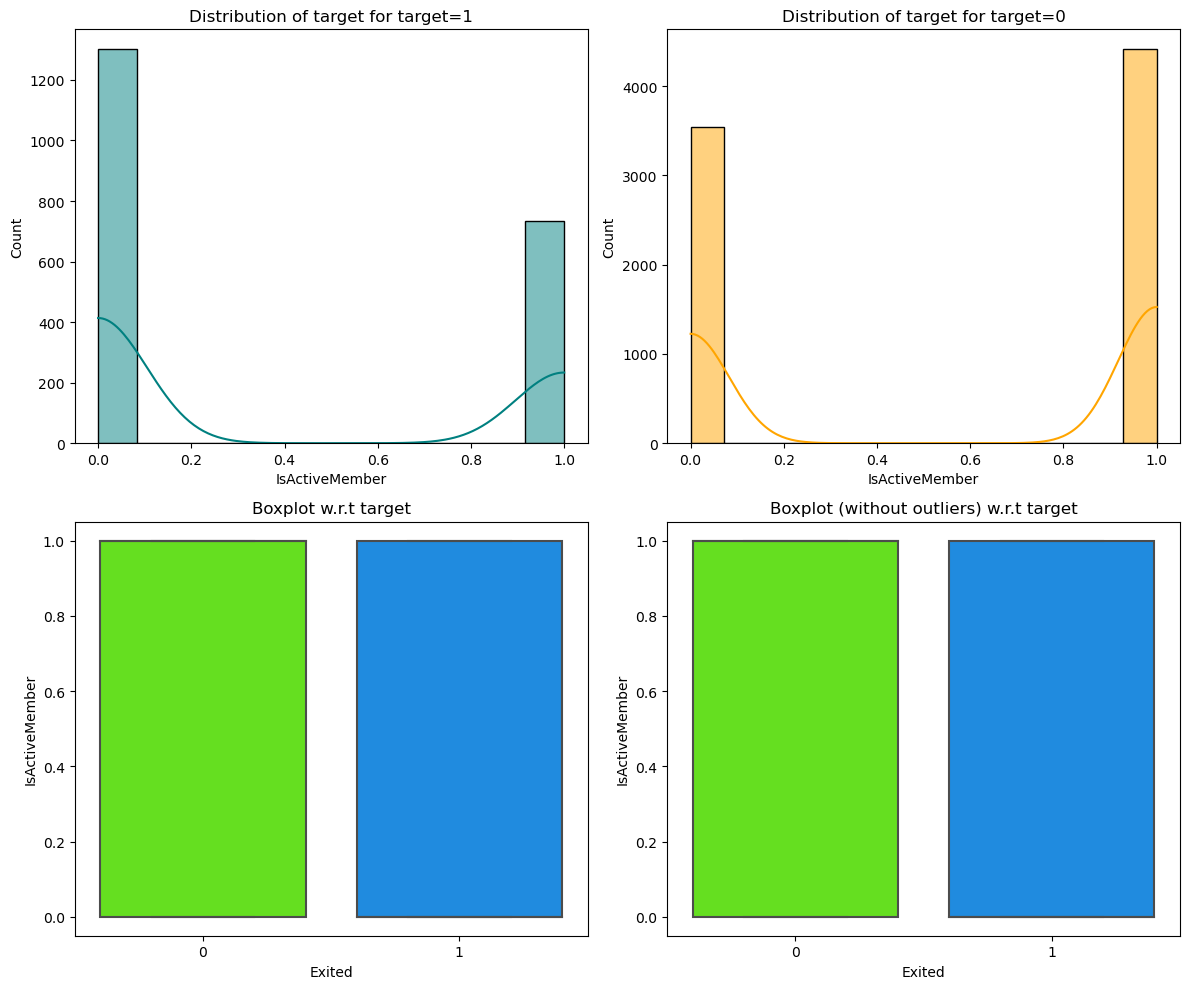

In [60]:
distribution_plot_wrt_target(data, 'IsActiveMember', 'Exited')

Exited             0     1    All
IsActiveMember                   
All             7963  2037  10000
0               3547  1302   4849
1               4416   735   5151
------------------------------------------------------------------------------------------------------------------------


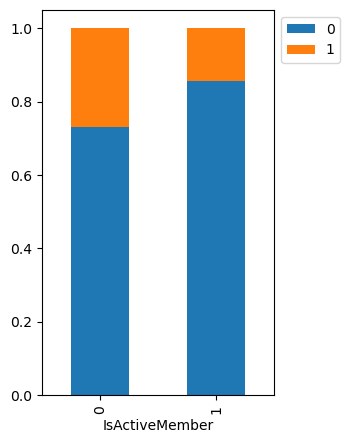

In [61]:
stacked_barplot(data, 'IsActiveMember', 'Exited')

#### `IsActiveMember` with `Exited`

- Active members have a lower `Exited` rate at _14 percent_.
- Non active members had nearly doubled `Exited` rate at _26.9 percent_.

### `EstimatedSalary` with `Exited`

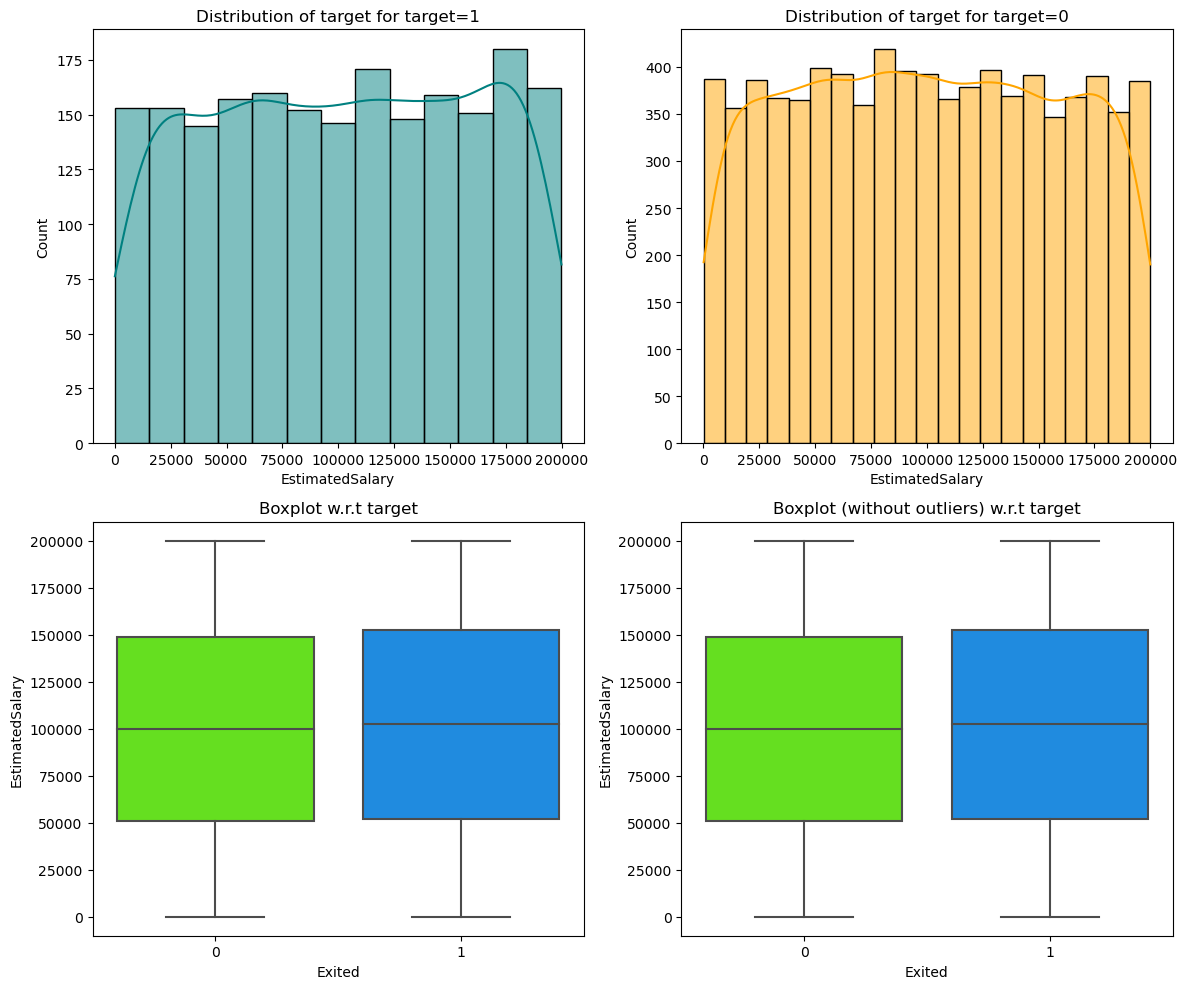

In [62]:
distribution_plot_wrt_target(data, 'EstimatedSalary', 'Exited')

#### `EstimatedSalary` with `Exited`

- There does not appear to be a distinctive `EstimatedSalary` and relationship with `Exited` customer.
- `EstimatedSalary` range is nearly equal for `Exited` and non-`Exited` customers.

### Univariate and Bivariate Analysis conclusion

- After Univariate and Bivariate Analysis, I will also drop `Surname` column.
- There are too many unique values and it will not add value to our model.

In [63]:
# drop Surname as this column will add not value to the model

data.drop(columns=['Surname'], inplace=True)

In [64]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


### This completes my Exploratory Data Analysis of column features to the target `Exited`.  Next step is Data Preprocessing.

---
---
---

## Data Preprocessing

* Missing value treatment
* Feature engineering (if needed)
* Outlier detection and treatment (if needed)
* Preparing data for modeling
* Any other preprocessing steps (if needed)

### Missing Value Treatment

- Check for missing values in the data

In [65]:
# check for missing values in the data

round(data.isnull().sum() / data.isnull().count() * 100, 2)

CreditScore        0.0
Geography          0.0
Gender             0.0
Age                0.0
Tenure             0.0
Balance            0.0
NumOfProducts      0.0
HasCrCard          0.0
IsActiveMember     0.0
EstimatedSalary    0.0
Exited             0.0
dtype: float64

**There are no missing values.**

### Outlier Detection

In [66]:
# calculate dataset's Q1, Q3, and IQR - Inter Quantile Range

Q1 = data.quantile(0.25, numeric_only=True)
Q3 = data.quantile(0.75, numeric_only=True)

IQR = Q3 - Q1

# Dataset Lower and Upper bounds
lower = (Q1 - 1.5 * IQR)
upper = (Q3 + 1.5 * IQR)

In [67]:
# Dataset outliers
((data.select_dtypes(include=['float64', 'int64']) < lower) |
                    (data.select_dtypes(include=['float64', 'int64']) > upper)).sum() / len(data) * 100

CreditScore         0.15
Age                 3.59
Tenure              0.00
Balance             0.00
NumOfProducts       0.60
HasCrCard           0.00
IsActiveMember      0.00
EstimatedSalary     0.00
Exited             20.37
dtype: float64

**There does not appear to be significant outliers in the dataset. `Age`, `CreditScore`, and `NumOfProducts` appear reasonable to a bank with varying customer profiles.**

### Review categorical `object` features

In [68]:
data['Geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

In [69]:
data['Gender'].value_counts()

Male      5457
Female    4543
Name: Gender, dtype: int64

### Data Preparation for Modeling

In [70]:
X = data.drop(['Exited'], axis=1)
y = data['Exited']

In [71]:
X.head()

CreditScore Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
0          619    France  Female   42       2       0.00              1   
1          608     Spain  Female   41       1   83807.86              1   
2          502    France  Female   42       8  159660.80              3   
3          699    France  Female   39       1       0.00              2   
4          850     Spain  Female   43       2  125510.82              1   

   HasCrCard  IsActiveMember  EstimatedSalary  
0          1               1        101348.88  
1          0               1        112542.58  
2          1               0        113931.57  
3          0               0         93826.63  
4          1               1         79084.10

In [72]:
y.head()

0    1
1    0
2    1
3    0
4    0
Name: Exited, dtype: int64

### Split dataset into Train, Validation, and Test

In [73]:
# Splitting data into training, validation and test set:

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=99, shuffle=True, stratify=y
)

# then we split the temporary set into train and validation

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=99, shuffle=True, stratify=y_temp
)

# Display each data set shape
print('Training set shape: ', X_train.shape)
print('Validation set shape:', X_val.shape)
print('Test set shape:', X_test.shape)

Training set shape:  (6000, 10)
Validation set shape: (2000, 10)
Test set shape: (2000, 10)


### Now that our dataset is split, normalize each subset

- Covert `Gender` with dummies.
- Covery `Geography` with dummies.
- Nomralize all numerical values so that currency column features do not over power the model.

In [74]:
X_train = pd.get_dummies(X_train, columns=['Gender', 'Geography'], drop_first=False)
X_val = pd.get_dummies(X_val, columns=['Gender', 'Geography'], drop_first=False)
X_test = pd.get_dummies(X_test, columns=['Gender', 'Geography'], drop_first=False)

In [75]:
X_train.head()

CreditScore  Age  Tenure    Balance  NumOfProducts  HasCrCard  \
8414          600   29       6   74430.10              2          1   
2997          655   26       7  106198.50              1          0   
8412          699   22       9   99339.00              1          1   
9333          755   78       5  121206.96              1          1   
2165          511   33       7       0.00              2          0   

      IsActiveMember  EstimatedSalary  Gender_Female  Gender_Male  \
8414               1         96051.10              1            0   
2997               1         32020.42              1            0   
8412               0         68297.61              0            1   
9333               1         76016.49              1            0   
2165               1        158313.87              0            1   

      Geography_France  Geography_Germany  Geography_Spain  
8414                 0                  1                0  
2997                 1                  0                0  
8412                 1                  0                0  
9333                 1                  0                0  
2165                 1                  0                0

In [76]:
X_val.head()

CreditScore  Age  Tenure    Balance  NumOfProducts  HasCrCard  \
5544          507   42       6       0.00              2          1   
6900          674   41       4  126605.14              1          1   
3565          676   30       5       0.00              2          0   
1198          584   38       9  104584.16              1          1   
4102          662   33       3       0.00              2          0   

      IsActiveMember  EstimatedSalary  Gender_Female  Gender_Male  \
5544               0         34777.23              0            1   
6900               1        166694.93              1            0   
3565               1        157888.50              1            0   
1198               0        176678.72              0            1   
4102               1         68064.83              0            1   

      Geography_France  Geography_Germany  Geography_Spain  
5544                 1                  0                0  
6900                 0                  0                1  
3565                 0                  0                1  
1198                 1                  0                0  
4102                 0                  0                1

In [77]:
X_test.head()

CreditScore  Age  Tenure    Balance  NumOfProducts  HasCrCard  \
9848          619   38      10  119658.49              1          1   
4041          593   36       2   70181.48              2          1   
4101          673   57       4       0.00              2          1   
560           584   29       7  105204.01              1          0   
7473          609   32       4   99883.16              1          1   

      IsActiveMember  EstimatedSalary  Gender_Female  Gender_Male  \
9848               1          8646.58              1            0   
4041               0         80608.12              0            1   
4101               1         49684.09              1            0   
560                1        138490.03              1            0   
7473               1        120594.85              0            1   

      Geography_France  Geography_Germany  Geography_Spain  
9848                 0                  0                1  
4041                 1                  0                0  
4101                 0                  0                1  
560                  0                  1                0  
7473                 0                  0                1

### Normalize Numerical Features

In [78]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6000 entries, 8414 to 2564
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        6000 non-null   int64  
 1   Age                6000 non-null   int64  
 2   Tenure             6000 non-null   int64  
 3   Balance            6000 non-null   float64
 4   NumOfProducts      6000 non-null   int64  
 5   HasCrCard          6000 non-null   int64  
 6   IsActiveMember     6000 non-null   int64  
 7   EstimatedSalary    6000 non-null   float64
 8   Gender_Female      6000 non-null   uint8  
 9   Gender_Male        6000 non-null   uint8  
 10  Geography_France   6000 non-null   uint8  
 11  Geography_Germany  6000 non-null   uint8  
 12  Geography_Spain    6000 non-null   uint8  
dtypes: float64(2), int64(6), uint8(5)
memory usage: 451.2 KB


In [79]:
# use StandardScaler to fit numerical values to a normal distribution curve.

sc = StandardScaler()
sc_fit = sc.fit(X_train[['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']])

# transform Train, Validation, and Test datasets
X_train[['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']] = sc_fit.transform(X_train[['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']])
X_val[['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']] = sc_fit.transform(X_val[['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']])
X_test[['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']] = sc_fit.transform(X_test[['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']])


In [80]:
X_train.tail()

CreditScore       Age    Tenure   Balance  NumOfProducts  HasCrCard  \
7461    -0.565299 -0.658746 -0.356437 -1.230433              2          0   
5446     0.148208 -1.036946  1.023988  1.836082              2          1   
6716    -1.402893 -0.942396 -0.356437  1.188979              2          1   
163      0.727285 -0.280546 -1.046650 -1.230433              2          1   
2564     0.168889 -0.091446  0.333775  1.083550              1          1   

      IsActiveMember  EstimatedSalary  Gender_Female  Gender_Male  \
7461               1         0.806230              0            1   
5446               0        -0.304414              0            1   
6716               0        -1.594147              0            1   
163                1         0.112335              1            0   
2564               1        -0.467242              1            0   

      Geography_France  Geography_Germany  Geography_Spain  
7461                 0                  0                1  
5446                 1                  0                0  
6716                 0                  0                1  
163                  0                  0                1  
2564                 1                  0                0

In [81]:
X_val.tail()

CreditScore       Age    Tenure   Balance  NumOfProducts  HasCrCard  \
2777     1.109890  2.083206  1.023988  0.778588              1          1   
9927     1.688968 -0.753296  0.333775  0.175794              1          1   
7134    -1.330508  0.192204 -0.011331  1.078995              1          1   
1606    -0.875519  0.097654 -1.046650  0.323651              2          1   
4640     0.375702  0.475855  1.369094 -1.230433              2          0   

      IsActiveMember  EstimatedSalary  Gender_Female  Gender_Male  \
2777               0         1.432594              1            0   
9927               0         1.543759              1            0   
7134               1        -1.506039              0            1   
1606               0         0.946349              1            0   
4640               0         0.043245              1            0   

      Geography_France  Geography_Germany  Geography_Spain  
2777                 0                  1                0  
9927                 1                  0                0  
7134                 1                  0                0  
1606                 0                  1                0  
4640                 1                  0                0

In [82]:
X_test.tail()

CreditScore       Age    Tenure   Balance  NumOfProducts  HasCrCard  \
4381    -1.640729  0.003104  0.678882 -1.230433              2          0   
4778     0.892736  0.570405 -1.046650 -1.230433              2          0   
2532     1.823397  1.988655 -1.046650 -1.230433              2          0   
3369     0.541153 -0.564196  1.023988  1.822685              1          1   
652      0.179230  0.286755 -0.701544  1.180143              1          1   

      IsActiveMember  EstimatedSalary  Gender_Female  Gender_Male  \
4381               1        -0.513587              0            1   
4778               1         1.353799              1            0   
2532               1        -0.701557              1            0   
3369               1        -0.361315              1            0   
652                0         0.132724              0            1   

      Geography_France  Geography_Germany  Geography_Spain  
4381                 1                  0                0  
4778                 0                  0                1  
2532                 1                  0                0  
3369                 1                  0                0  
652                  1                  0                0

### Data preperation complete for Train, Validation, and Test.  Next step, Model Building.

---
---
---

## Model Building

### Model Evaluation Criterion

### The model can make wrong predictions in the following ways:

- **Scenario 1 (False Positive - FP)**: Predicting a customer is planning to leave the bank, when the customer is not.
- **Scenario 2 (False Negative - FN)**: Predicting a customer is planning to stay with the bank, when the customer is planning to leave.

### Which case is more important?

-  Minimizing **Scenario 2 (False Negative)** is more important to the bank.  Lossing a customer is more costly to bank.

### How to reduce the customer loss?  Reduce Scenario 2 - False Negative.

- The model should optimize to reduce **False Negative**.  The model metric to maximize is **`Recall` score**.

### Model Building: Neural Network

In [83]:
# support function to display Confusion Matrix

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))



    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    
    if title:
        plt.title(title)

### Model 1 - Build the Neural Network model with SGD as an optimizer

- First, flush and initialize Tensorflow/Keras cache.
- Initialize random number seed generator to allow replication of results.

In [84]:
# flush Tensorflow/Keras cache
backend.clear_session()

# Fix random number seed for replication of results
np.random.seed(99)
random.seed(99)
tf.random.set_seed(99)

In [85]:
# Initialize ANN
model1 = Sequential()
model1.add(Dense(activation='relu', input_dim=13, units=64)) # input layer
model1.add(Dense(32, activation='relu')) # hidden layer
model1.add(Dense(1, activation='sigmoid')) # output layer - using sigmoid for probability outcomes

In [87]:
# Create SGD optimizer with default learning rate
# Loss function - binary cross entropy
model1.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['accuracy'])

In [88]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                896       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3009 (11.75 KB)
Trainable params: 3009 (11.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Model 1 summary observations:

```
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 dense (Dense)               (None, 64)                896 = 13 features * 64 input nodes + 64 input nodes
                                                                 
 dense_1 (Dense)             (None, 32)                2080 = 64 input nodes * 32 hidden nodes
                                                                 
 dense_2 (Dense)             (None, 1)                 33 = 32 hidden nodes + 1 target/output node
                                                             
```

### Fit `Model 1` to the Training dataset for 100 epochs

In [89]:
history1 = model1.fit(X_train, y_train,
                     validation_split=0.2,
                     epochs=100,
                     batch_size=32,
                     verbose=2)

Epoch 1/100
150/150 - 0s - loss: 0.5216 - accuracy: 0.7840 - val_loss: 0.5107 - val_accuracy: 0.7867 - 237ms/epoch - 2ms/step
Epoch 2/100
150/150 - 0s - loss: 0.4711 - accuracy: 0.7985 - val_loss: 0.4895 - val_accuracy: 0.7867 - 52ms/epoch - 349us/step
Epoch 3/100
150/150 - 0s - loss: 0.4542 - accuracy: 0.7981 - val_loss: 0.4766 - val_accuracy: 0.7883 - 57ms/epoch - 381us/step
Epoch 4/100
150/150 - 0s - loss: 0.4436 - accuracy: 0.7979 - val_loss: 0.4685 - val_accuracy: 0.7867 - 56ms/epoch - 372us/step
Epoch 5/100
150/150 - 0s - loss: 0.4363 - accuracy: 0.7979 - val_loss: 0.4610 - val_accuracy: 0.7875 - 55ms/epoch - 369us/step
Epoch 6/100
150/150 - 0s - loss: 0.4310 - accuracy: 0.8004 - val_loss: 0.4562 - val_accuracy: 0.7883 - 53ms/epoch - 351us/step
Epoch 7/100
150/150 - 0s - loss: 0.4268 - accuracy: 0.8044 - val_loss: 0.4513 - val_accuracy: 0.7858 - 55ms/epoch - 365us/step
Epoch 8/100
150/150 - 0s - loss: 0.4239 - accuracy: 0.8104 - val_loss: 0.4486 - val_accuracy: 0.7908 - 54ms/epoc

150/150 - 0s - loss: 0.3728 - accuracy: 0.8490 - val_loss: 0.3961 - val_accuracy: 0.8308 - 49ms/epoch - 326us/step
Epoch 66/100
150/150 - 0s - loss: 0.3717 - accuracy: 0.8471 - val_loss: 0.3950 - val_accuracy: 0.8317 - 49ms/epoch - 326us/step
Epoch 67/100
150/150 - 0s - loss: 0.3706 - accuracy: 0.8454 - val_loss: 0.3947 - val_accuracy: 0.8342 - 49ms/epoch - 327us/step
Epoch 68/100
150/150 - 0s - loss: 0.3697 - accuracy: 0.8467 - val_loss: 0.3940 - val_accuracy: 0.8358 - 48ms/epoch - 321us/step
Epoch 69/100
150/150 - 0s - loss: 0.3689 - accuracy: 0.8483 - val_loss: 0.3924 - val_accuracy: 0.8350 - 48ms/epoch - 320us/step
Epoch 70/100
150/150 - 0s - loss: 0.3675 - accuracy: 0.8485 - val_loss: 0.3917 - val_accuracy: 0.8333 - 49ms/epoch - 330us/step
Epoch 71/100
150/150 - 0s - loss: 0.3665 - accuracy: 0.8483 - val_loss: 0.3899 - val_accuracy: 0.8358 - 49ms/epoch - 328us/step
Epoch 72/100
150/150 - 0s - loss: 0.3657 - accuracy: 0.8483 - val_loss: 0.3886 - val_accuracy: 0.8367 - 48ms/epoch - 

63/63 [==============================] - 0s 337us/step - loss: 0.3472 - accuracy: 0.8550


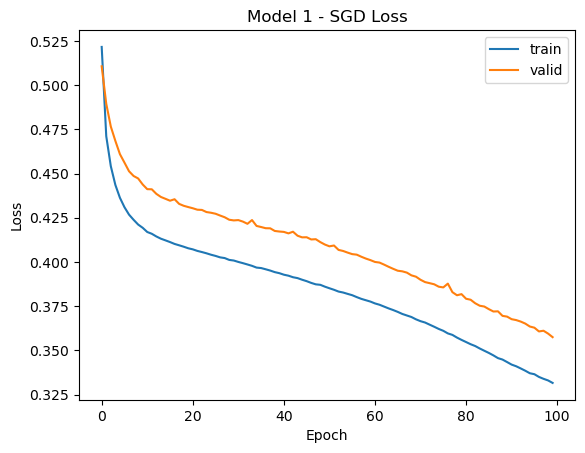

In [102]:
# Capturing learning history per epoch
hist  = pd.DataFrame(history1.history)
hist['epoch'] = history1.epoch

# Plotting accuracy at different epochs
plt.title('Model 1 - SGD Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.legend(("train" , "valid") , loc=0)

#Printing results
results = model1.evaluate(X_test, y_test)

### Model 1 - Confusion Matrix | Performance Summary Results

In [91]:
y_pred1 = model1.predict(X_val)
y_pred1 = (y_pred1 > 0.5)
y_pred1

63/63 [==============================] - 0s 303us/step


array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

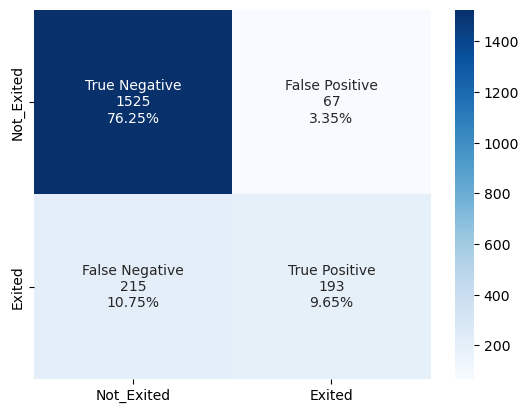

In [93]:
#Calculating the confusion matrix 

cm=confusion_matrix(y_val, y_pred1)
labels = ['True Negative','False Positive','False Negative','True Positive']
categories = [ 'Not_Exited','Exited']
make_confusion_matrix(cm, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

### Model 1 - SGD -  Classification Report

In [103]:
# Accuracy as per the classification report 
cr = metrics.classification_report(y_val,y_pred1)
print(cr)

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1592
           1       0.74      0.47      0.58       408

    accuracy                           0.86      2000
   macro avg       0.81      0.72      0.75      2000
weighted avg       0.85      0.86      0.85      2000



#### Model 1 - SGD observations:

```
             precision    recall  f1-score   support

           0       0.88      0.96      0.92      1592
           1       0.74      0.47      0.58       408

    accuracy                           0.86      2000
   macro avg       0.81      0.72      0.75      2000
weighted avg       0.85      0.86      0.85      2000
```

- The goal is to improve **`Recall`**.  Model 1 performance is **_47 percent_.**
- Model 2 will try to improve the model by finding the optimal threshold using `ROC-AUC` curve.
- I will build a model with the `Adam` optimizer.

### Model 2 - `Adam` Optimizer and `ROC-AUC` Curve


In [378]:
# clear TF/Keras session | initialize and fix random number seed generator
backend.clear_session()
np.random.seed(99)
random.seed(99)
tf.random.set_seed(99)

In [379]:
model2 = Sequential()

# add input layer
model2.add(Dense(32, activation='relu', kernel_initializer='he_uniform', input_dim=X_train.shape[1]))
# add hidden layers
model2.add(Dense(16, activation='relu'))
model2.add(Dense(8, activation='relu'))
# add output layer
model2.add(Dense(1, activation='sigmoid'))

# compile ANN with Adam optimizer and binary cross entropy loss function
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model2.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [380]:
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                448       
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1121 (4.38 KB)
Trainable params: 1121 (4.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [381]:
# fit Model 2 - Adam
history2 = model2.fit(X_train, y_train, batch_size=32, epochs=50, verbose=1, validation_data=[X_val, y_val])

Epoch 1/50
188/188 [==============================] - 0s 700us/step - loss: 0.4999 - accuracy: 0.7963 - val_loss: 0.4443 - val_accuracy: 0.7955
Epoch 2/50
188/188 [==============================] - 0s 432us/step - loss: 0.4401 - accuracy: 0.7970 - val_loss: 0.4308 - val_accuracy: 0.7990
Epoch 3/50
188/188 [==============================] - 0s 420us/step - loss: 0.4289 - accuracy: 0.7998 - val_loss: 0.4290 - val_accuracy: 0.7975
Epoch 4/50
188/188 [==============================] - 0s 425us/step - loss: 0.4256 - accuracy: 0.8007 - val_loss: 0.4288 - val_accuracy: 0.8025
Epoch 5/50
188/188 [==============================] - 0s 431us/step - loss: 0.4190 - accuracy: 0.8078 - val_loss: 0.4275 - val_accuracy: 0.8090
Epoch 6/50
188/188 [==============================] - 0s 433us/step - loss: 0.4165 - accuracy: 0.8108 - val_loss: 0.4233 - val_accuracy: 0.8085
Epoch 7/50
188/188 [==============================] - 0s 433us/step - loss: 0.4124 - accuracy: 0.8112 - val_loss: 0.4202 - val_accuracy:

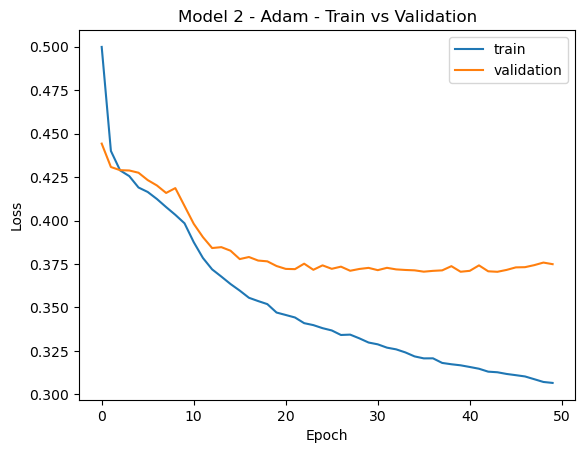

In [382]:
# Model 2 - Plot Train Loss vs Validation Loss

plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model 2 - Adam - Train vs Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc=0)
plt.show()

#### Model 2 - Adam observations:

- We can see that `Model 2` performance drops off quickly.
- We can see that the model is severely overfit.
- Use the `ROC-AUC` curve to determine best fit.

### Model 2 - Adam Optimizer and ROC-AUC Curve

188/188 [==============================] - 0s 241us/step
Best Threshold=0.153603, G-Mean=0.822


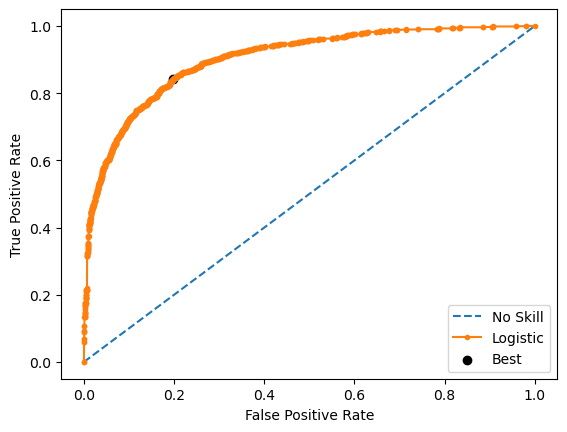

In [383]:
# predict probabilities
yhat2 = model2.predict(X_train)

# keep probabilties for positive outcomes only
yhat2 = yhat2[:, 0]

# calculate ROC curves
fpr, tpr, thresholds2 = roc_curve(y_train, yhat2)
# calculate the G-Mean for each threshold
gmeans2 = np.sqrt(tpr * (1 - fpr))
# locate the index of the largest G-Mean
ix = np.argmax((gmeans2))
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds2[ix], gmeans2[ix]))

# plot the ROC curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.show()


### Tuning the threshold using ROC-AUC


There are many ways we could locate the threshold with the optimal balance between **False Positive** and **True Positive** rates.

- **Sensitivity**: True Positive rate
- **Specificity**: Inverse of the false-positive rate

```
Sensitivity = True Positive / (True Positive + False Negative)

Specificity = True Negative / (False Positive + True Negative)
```

Where:

```
Sensitivity = True Positive Rate

Specificity = 1 – False Positive Rate
```

#### Geometric Mean or G-Mean

The Geometric Mean or G-Mean is a metric for imbalanced classification that, if optimized, will seek a balance between the sensitivity and the specificity.

```
G-Mean = sqrt(Sensitivity * Specificity)
```

One approach would be to test the model with each threshold returned from the call `roc_auc_score()`, and select the threshold with the **largest G-Mean value.**

---

### Model 2 - Adam | Predict the results using the Best as a Threshold

In [384]:
y_pred2 = model2.predict(X_val)
y_pred2 = (y_pred2 > thresholds2[ix])
y_pred2

63/63 [==============================] - 0s 265us/step


array([[False],
       [False],
       [False],
       ...,
       [False],
       [ True],
       [False]])

### Model 2 - Adam | Confusion Matrix

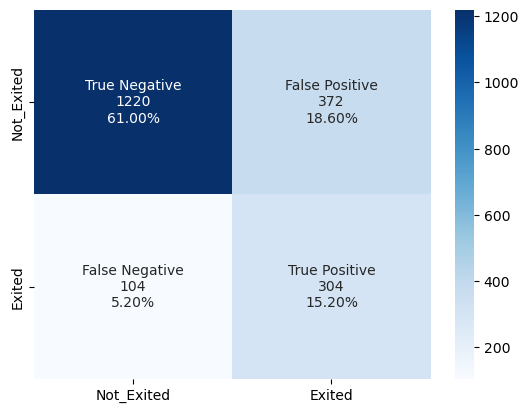

In [385]:
cm=confusion_matrix(y_val, y_pred2)
labels = ['True Negative','False Positive','False Negative','True Positive']
categories = [ 'Not_Exited','Exited']
make_confusion_matrix(cm, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

### Model 2 - Adam | Classification Report

In [386]:
# model 2 classification report
cr = metrics.classification_report(y_val, y_pred2)
print(cr)

              precision    recall  f1-score   support

           0       0.92      0.77      0.84      1592
           1       0.45      0.75      0.56       408

    accuracy                           0.76      2000
   macro avg       0.69      0.76      0.70      2000
weighted avg       0.83      0.76      0.78      2000



#### Model 2 - Adam observations:


- **`Recall` imporved to _75 percent_**, which is a marked improvement from Model 1.
- Next, build a model with Dropout and Adam optimizer.

### Model 3 -  Build a model with Dropout and Adam Optimizer

In [433]:
# clear TF/Keras session
backend.clear_session()

# Fix random number seed for replication of results
np.random.seed(99)
random.seed(99)
tf.random.set_seed(99)

In [434]:
# Model 3 - Adam Optimizer with Dropout

model3 = Sequential()
model3.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
model3.add(Dropout(0.4))
model3.add(Dense(32, activation='relu'))
model3.add(Dropout(0.3))
model3.add(Dense(16, activation='relu'))
model3.add(Dropout(0.3))
model3.add(Dense(8, activation='relu'))
model3.add(Dense(1, activation='sigmoid'))

In [435]:
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                896       
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 8)                 1

In [436]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model3.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [437]:
# fit the model to the training data
history3 = model3.fit(X_train, y_train, batch_size=32, epochs=100, verbose=1, validation_data=(X_val, y_val))

Epoch 1/100
188/188 [==============================] - 0s 754us/step - loss: 0.5238 - accuracy: 0.7705 - val_loss: 0.4448 - val_accuracy: 0.7960
Epoch 2/100
188/188 [==============================] - 0s 498us/step - loss: 0.4754 - accuracy: 0.7960 - val_loss: 0.4329 - val_accuracy: 0.7960
Epoch 3/100
188/188 [==============================] - 0s 490us/step - loss: 0.4558 - accuracy: 0.7947 - val_loss: 0.4288 - val_accuracy: 0.7955
Epoch 4/100
188/188 [==============================] - 0s 487us/step - loss: 0.4473 - accuracy: 0.7960 - val_loss: 0.4310 - val_accuracy: 0.8045
Epoch 5/100
188/188 [==============================] - 0s 492us/step - loss: 0.4427 - accuracy: 0.8037 - val_loss: 0.4246 - val_accuracy: 0.8090
Epoch 6/100
188/188 [==============================] - 0s 478us/step - loss: 0.4392 - accuracy: 0.8022 - val_loss: 0.4234 - val_accuracy: 0.8175
Epoch 7/100
188/188 [==============================] - 0s 486us/step - loss: 0.4328 - accuracy: 0.8070 - val_loss: 0.4186 - val_ac

### Model 3 - Adam with Dropout | Plot Loss Function

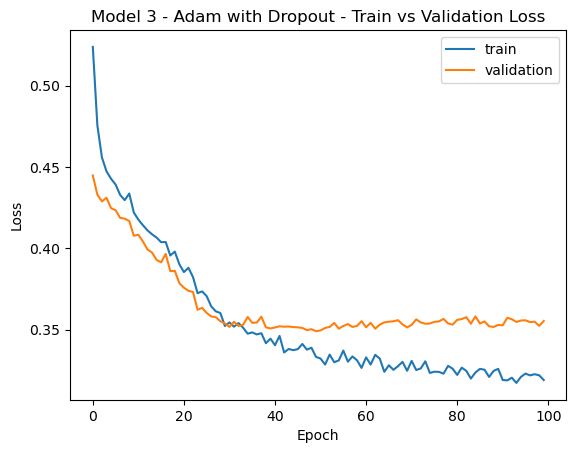

In [438]:
# plot Train Loss vs Validation Loss

plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Model 3 - Adam with Dropout - Train vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc=0)

plt.show()

### Model 3 - Adam with Dropout | Predict using ROC-AUC Curve

188/188 [==============================] - 0s 253us/step
Best Threshold=0.217811, G-Mean=0.823


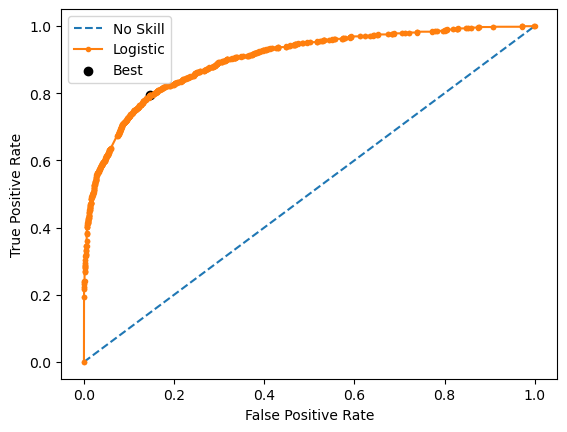

In [440]:
# predict probabilities
yhat3 = model3.predict(X_train)

# keep probabilties for positive outcomes only
yhat3 = yhat3[:, 0]

# calculate ROC curves
fpr, tpr, thresholds3 = roc_curve(y_train, yhat3)
# calculate the G-Mean for each threshold
gmeans3 = np.sqrt(tpr * (1 - fpr))
# locate the index of the largest G-Mean
ix = np.argmax((gmeans3))
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds3[ix], gmeans3[ix]))

# plot the ROC curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.show()

In [441]:
# predict using Best Threshold
y_pred3 = model3.predict(X_val)
y_pred3 = (y_pred3 > thresholds3[ix])
y_pred3

63/63 [==============================] - 0s 275us/step


array([[False],
       [False],
       [False],
       ...,
       [False],
       [ True],
       [False]])

### Model 3 - Adam with Dropout | Confusion Matrix

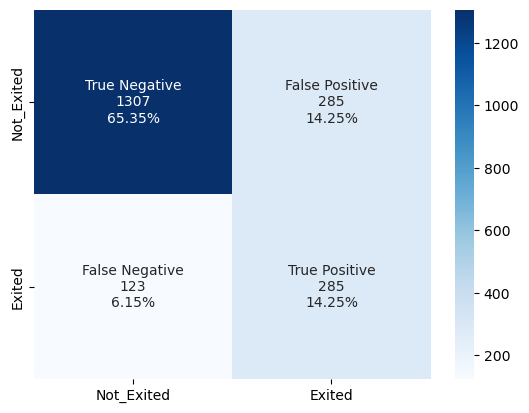

In [442]:
cm=confusion_matrix(y_val, y_pred3)
labels = ['True Negative','False Positive','False Negative','True Positive']
categories = [ 'Not_Exited','Exited']
make_confusion_matrix(cm, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

### Model 3 - Adam with Dropout | Classification Repot

In [443]:
# model 3 classification report
cr = metrics.classification_report(y_val, y_pred3)
print(cr)

              precision    recall  f1-score   support

           0       0.91      0.82      0.86      1592
           1       0.50      0.70      0.58       408

    accuracy                           0.80      2000
   macro avg       0.71      0.76      0.72      2000
weighted avg       0.83      0.80      0.81      2000



#### Model 3 - Adam with Dropout observations:

- **`Recall`** score dropped to **_70 percent_.**
- Next, build a model using Hyperparameter Tuning to attempt better model performance.

### Model 4:  Adam Optimizer and GridSearchCV Hyperparameter Tuning

In [445]:
# clear TF/Keras session
backend.clear_session()

# Fix random number seed for replication of results
np.random.seed(99)
random.seed(99)
tf.random.set_seed(99)

In [446]:
def create_model4(lr, batch_size=64):
    np.random.seed(2024)
    
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
    model.add(Dropout(0.40))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.30))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.30))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    # compile model
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

### Model 4 - Use Grid Search to optimizer for `Batch Size` and `Learning Rate`

In [447]:
# using Keras Classifier
keras_estimator = KerasClassifier(model=create_model4, lr=0.01, verbose=1)

# Grid Parameters
param_grid = {
    'batch_size': [4, 8, 16, 32, 64, 128],
    'lr': [0.1, 0.01, 0.001, 0.0001, 0.00001],
}

kfold_splits = 3
grid = GridSearchCV(estimator=keras_estimator,
                   verbose=1,
                   cv=kfold_splits,
                   param_grid=param_grid,
                   n_jobs=-1)

In [448]:
# time the Grid Search total runtime
import time

# store start time
begin = time.time()

grid_result = grid.fit(X_train, y_train, validation_data=(X_val, y_val), verbose=1)

# summarize results
print('Best: %f using %s' % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

time.sleep(1)
# store end time
end = time.time()

# total time
print(f'Total runtime of Grid Search is {end - begin} seconds')

Fitting 3 folds for each of 30 candidates, totalling 90 fits


500/500 [==============================] - 1s 2ms/step


 307/1000 [========>.....................] - ETA: 9s - loss: 1.1567 - accuracy: 0.4919

 795/1000 [======================>.......] - ETA: 3s - loss: 0.6865 - accuracy: 0.6764

241/500 [=============>................] - ETA: 1s - loss: 829.7287 - accuracy: 0.68

451/500 [==========================>...] - ETA: 0s - loss: 807.3856 - accuracy: 0.68

  6/500 [..............................] - ETA: 11s - loss: 6.1709 - accuracy: 0.4792

 20/500 [>.............................] - ETA: 8s - loss: 0.8250 - accuracy: 0.68752

282/500 [===============>..............] - ETA: 2s - loss: 0.5052 - accuracy: 0.7766

450/500 [==========================>...] - ETA: 0s - loss: 0.4970 - accuracy: 0.7806

237/250 [===========================>..] - ETA: 0s - loss: 0.7735 - accuracy: 0.69

344/500 [===================>..........] - ETA: 2s - loss: 0.5732 - accuracy: 0.7547

 75/500 [===>..........................] - ETA: 6s - loss: 1.2452 - accuracy: 0.5500

398/500 [======================>.......] - ETA: 1s - loss: 0.7549 - accuracy: 0.6523

435/500 [=========================>....] - ETA: 0s - loss: 0.9536 - accuracy: 0.5670

 51/250 [=====>........................] - ETA: 3s - loss: 34.5318 - accuracy: 0.6998

250/250 [==============================] - ETA: 0s - loss: 308.3585 - accuracy: 0.6762

 95/250 [==========>...................] - ETA: 1s - loss: 123.3696 - accuracy: 0.6546

 33/250 [==>...........................] - ETA: 2s - loss: 0.7015 - accuracy: 0.7348

 58/250 [=====>........................] - ETA: 2s - loss: 0.6384 - accuracy: 0.7317

 96/250 [==========>...................] - ETA: 2s - loss: 0.6320 - accuracy: 0.7461

147/250 [================>.............] - ETA: 1s - loss: 0.6393 - accuracy: 0.6879

247/250 [============================>.] - ETA: 0s - loss: 0.6135 - accuracy: 0.7373

 51/250 [=====>........................] - ETA: 2s - loss: 0.8865 - accuracy: 0.5061

 95/250 [==========>...................] - ETA: 1s - loss: 0.8769 - accuracy: 0.5007

185/250 [=====================>........] - ETA: 0s - loss: 0.7489 - accuracy: 0.6639

168/250 [===================>..........] - ETA: 1s - loss: 0.7505 - accuracy: 0.6101

  9/125 [=>............................] - ETA: 1s - loss: 0.6679 - accuracy: 0.6979

 20/125 [===>..........................] - ETA: 2s - loss: 0.6751 - accuracy: 0.6938

 10/125 [=>............................] - ETA: 2s - loss: 1.0029 - accuracy: 0.4969  

 76/125 [=================>............] - ETA: 0s - loss: 0.7256 - accuracy: 0.7418

 53/125 [===========>..................] - ETA: 1s - loss: 0.6687 - accuracy: 0.6238

  1/125 [..............................] - ETA: 1:56 - loss: 1.9246 - accuracy: 0.1875

 69/125 [===============>..............] - ETA: 0s - loss: 0.9136 - accuracy: 0.5938

35/63 [===============>..............] - ETA: 0s1s - loss: 1.0422 - accuracy: 0.45

 99/125 [======================>.......] - ETA: 0s - loss: 1.0044 - accuracy: 0.4833

115/125 [==========================>...] - ETA: 0s - loss: 1.0258 - accuracy: 0.4533

18/63 [=======>......................] - ETA: 0s - loss: 49.0562 - accuracy: 0.661 

59/63 [===========================>..] - ETA: 0s - loss: 41.0787 - accuracy: 0.6690

43/63 [===================>..........] - ETA: 0s - loss: 75.7650 - accuracy: 0.6635

52/63 [=======================>......] - ETA: 0s - loss: 83.2710 - accuracy: 0.6665

32/32 [==============================] - 1s 13ms/stepss: 0.5097 - accuracy: 0.78


30/63 [=============>................] - ETA: 1s - loss: 0.6814 - accuracy: 0.7245

36/63 [================>.............] - ETA: 0s - loss: 0.5762 - accuracy: 0.7461

43/63 [===================>..........] - ETA: 0s - loss: 0.7304 - accuracy: 0.5832

24/63 [==========>...................] - ETA: 0s - loss: 0.9237 - accuracy: 0.5319

63/63 [==============================] - ETA: 0s - loss: 0.8575 - accuracy: 0.5667

32/32 [==============================] - 0s 10ms/stepss: 1.5448 - accuracy: 0.46


18/32 [===============>..............] - ETA: 0s - loss: 53.4882 - accuracy: 0.6710

23/32 [====================>.........] - ETA: 0s

21/32 [==================>...........] - ETA: 0s - loss: 0.5978 - accuracy: 0.7407

32/32 [==============================] - 3s 63ms/step - loss: 74.4318 - accuracy: 0.6535 - val_loss: 136.5871 - val_accuracy: 0.7960


22/32 [===================>..........] - ETA: 0s - loss: 0.5455 - accuracy: 0.7653

31/32 [============================>.] - ETA: 0s - loss: 0.5365 - accuracy: 0.7684

 3/32 [=>............................] - ETA: 0s - loss: 0.7740 - accuracy: 0.5365 

20/32 [=================>............] - ETA: 0s - loss: 1.1348 - accuracy: 0.5469

27/32 [========================>.....] - ETA: 0s - loss: 0.7448 - accuracy: 0.5770

16/16 [==============================] - 0s 2ms/step


94/94 [==============================] - 0s 1ms/step - loss: 0.4826 - accuracy: 0.7908 - val_loss: 0.4326 - val_accuracy: 0.7960
Best: 0.798500 using {'batch_size': 64, 'lr': 0.01}
Total runtime of Grid Search is 121.00138092041016 seconds


### Model 4 - Results Grid Search Best Params

```
Best: 0.798500 using {'batch_size': 64, 'lr': 0.01}
Total runtime of Grid Search is 117.23803901672363 seconds
```

**Create a model with the best parameters**

In [455]:
model4 = create_model4(lr=grid_result.best_params_['lr'], batch_size=grid_result.best_params_['batch_size'])

In [456]:
model4.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 64)                896       
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 16)                528       
                                                                 
 dropout_5 (Dropout)         (None, 16)                0         
                                                                 
 dense_8 (Dense)             (None, 8)                

### Model 4 - Fit model based on Grid Search Best Params

In [457]:
optimizer = tf.keras.optimizers.Adam(grid_result.best_params_['lr'])
model4.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history4 = model4.fit(X_train, y_train, epochs=100, batch_size=grid_result.best_params_['batch_size'], validation_data=(X_val, y_val), verbose=1)

Epoch 1/100
94/94 [==============================] - 0s 1ms/step - loss: 0.4731 - accuracy: 0.7972 - val_loss: 0.4265 - val_accuracy: 0.8065
Epoch 2/100
94/94 [==============================] - 0s 618us/step - loss: 0.4484 - accuracy: 0.8017 - val_loss: 0.4234 - val_accuracy: 0.8030
Epoch 3/100
94/94 [==============================] - 0s 625us/step - loss: 0.4356 - accuracy: 0.8098 - val_loss: 0.4129 - val_accuracy: 0.8305
Epoch 4/100
94/94 [==============================] - 0s 582us/step - loss: 0.4282 - accuracy: 0.8197 - val_loss: 0.4112 - val_accuracy: 0.8420
Epoch 5/100
94/94 [==============================] - 0s 560us/step - loss: 0.4094 - accuracy: 0.8227 - val_loss: 0.3912 - val_accuracy: 0.8360
Epoch 6/100
94/94 [==============================] - 0s 573us/step - loss: 0.4124 - accuracy: 0.8267 - val_loss: 0.3881 - val_accuracy: 0.8430
Epoch 7/100
94/94 [==============================] - 0s 552us/step - loss: 0.4002 - accuracy: 0.8332 - val_loss: 0.3867 - val_accuracy: 0.8505
E

Epoch 58/100
94/94 [==============================] - 0s 596us/step - loss: 0.3510 - accuracy: 0.8545 - val_loss: 0.3527 - val_accuracy: 0.8620
Epoch 59/100
94/94 [==============================] - 0s 589us/step - loss: 0.3533 - accuracy: 0.8553 - val_loss: 0.3660 - val_accuracy: 0.8530
Epoch 60/100
94/94 [==============================] - 0s 604us/step - loss: 0.3558 - accuracy: 0.8528 - val_loss: 0.3663 - val_accuracy: 0.8570
Epoch 61/100
94/94 [==============================] - 0s 585us/step - loss: 0.3515 - accuracy: 0.8562 - val_loss: 0.3564 - val_accuracy: 0.8605
Epoch 62/100
94/94 [==============================] - 0s 640us/step - loss: 0.3484 - accuracy: 0.8560 - val_loss: 0.3650 - val_accuracy: 0.8565
Epoch 63/100
94/94 [==============================] - 0s 620us/step - loss: 0.3534 - accuracy: 0.8540 - val_loss: 0.3515 - val_accuracy: 0.8625
Epoch 64/100
94/94 [==============================] - 0s 580us/step - loss: 0.3520 - accuracy: 0.8575 - val_loss: 0.3621 - val_accuracy:

### Model 4 - Adam with Grid Search | Plot Train vs Validation Loss

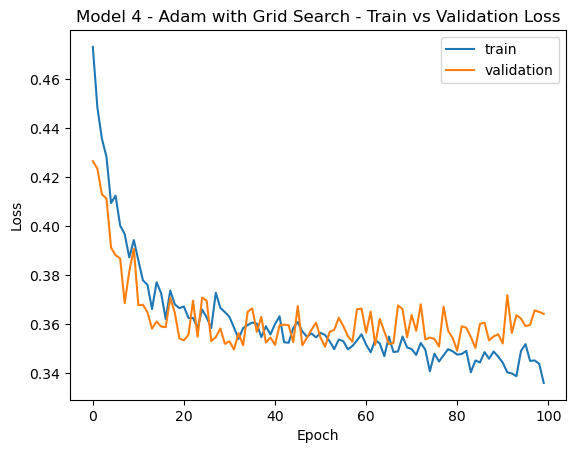

In [458]:
# plot Train Loss vs Validation Loss

plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('Model 4 - Adam with Grid Search - Train vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc=0)

plt.show()

#### Model 4 Loss Function observations:

- Grid Search helped determine more appropriate nodes for the Neural Network.  
- Training and Validation are following similar curves.

### Model 4 - Adam Grid Search | ROC-AUC Best Threshold

188/188 [==============================] - 0s 266us/step
Best Threshold=0.207647, G-Mean=0.815


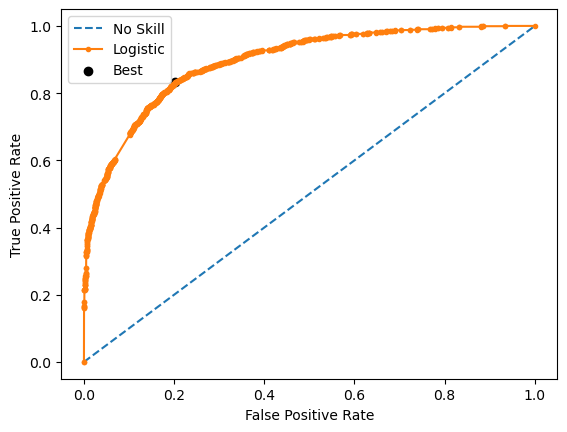

In [459]:
# predict probabilities
yhat4 = model4.predict(X_train)

# keep probabilties for positive outcomes only
yhat4 = yhat4[:, 0]

# calculate ROC curves
fpr, tpr, thresholds4 = roc_curve(y_train, yhat4)
# calculate the G-Mean for each threshold
gmeans4 = np.sqrt(tpr * (1 - fpr))
# locate the index of the largest G-Mean
ix = np.argmax((gmeans4))
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds4[ix], gmeans4[ix]))

# plot the ROC curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.show()

In [460]:
# predict using Best Threshold
y_pred4 = model4.predict(X_val)
y_pred4 = (y_pred4 > thresholds4[ix])
y_pred4

63/63 [==============================] - 0s 259us/step


array([[False],
       [False],
       [False],
       ...,
       [ True],
       [False],
       [False]])

### Model 4 - Adam with Grid Search | Confusion Matrix

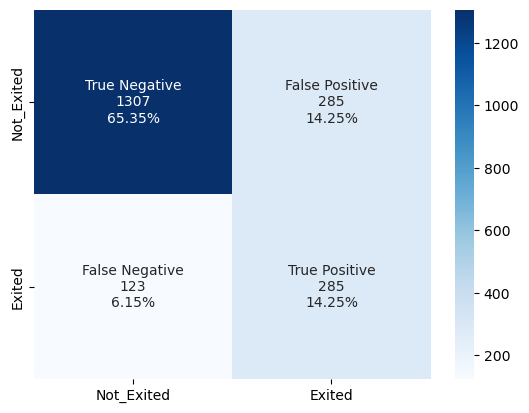

In [461]:
cm=confusion_matrix(y_val, y_pred3)
labels = ['True Negative','False Positive','False Negative','True Positive']
categories = [ 'Not_Exited','Exited']
make_confusion_matrix(cm, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

### Model 4 - Adam with Grid Search | Classification Report

In [462]:
# model 4 classification report
cr = metrics.classification_report(y_val, y_pred4)
print(cr)

              precision    recall  f1-score   support

           0       0.92      0.76      0.84      1592
           1       0.45      0.75      0.56       408

    accuracy                           0.76      2000
   macro avg       0.69      0.76      0.70      2000
weighted avg       0.83      0.76      0.78      2000



#### Model 4 Classification Report observations:

- **`Recall`** is **_75 percent_**.
- Results are comparable to Model 2.
- Next, build a model with Adam Optimizer and Batch Normalization.

### Model 5 - Adam with Batch Normalization

In [503]:
# clear TF/Keras session
backend.clear_session()

# Fix random number seed for replication of results
np.random.seed(99)
random.seed(99)
tf.random.set_seed(99)

In [504]:
# build model using Adam optimizer with Batch Normalization
model5 = Sequential()

model5.add(Dense(128, activation='relu', kernel_initializer='he_uniform', input_dim=X_train.shape[1]))
#model5.add(BatchNormalization(epsilon=0.001, momentum=0.7))
model5.add(BatchNormalization(epsilon=0.0001, momentum=0.7))
model5.add(Dense(64, activation='relu'))
model5.add(BatchNormalization(epsilon=0.001, momentum=0.3))
model5.add(Dense(32, activation='relu'))
model5.add(Dense(1, activation='sigmoid'))

In [505]:
model5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1792      
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 3

In [506]:
optimizer = tf.keras.optimizers.Adam(0.001)
model5.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [507]:
history5 = model5.fit(X_train, y_train, batch_size=64, epochs=50, validation_data=(X_val, y_val), verbose=1)

Epoch 1/50
94/94 [==============================] - 0s 1ms/step - loss: 0.4416 - accuracy: 0.8063 - val_loss: 0.3959 - val_accuracy: 0.8380
Epoch 2/50
94/94 [==============================] - 0s 664us/step - loss: 0.3706 - accuracy: 0.8433 - val_loss: 0.3768 - val_accuracy: 0.8455
Epoch 3/50
94/94 [==============================] - 0s 653us/step - loss: 0.3420 - accuracy: 0.8580 - val_loss: 0.3691 - val_accuracy: 0.8475
Epoch 4/50
94/94 [==============================] - 0s 661us/step - loss: 0.3290 - accuracy: 0.8637 - val_loss: 0.3718 - val_accuracy: 0.8365
Epoch 5/50
94/94 [==============================] - 0s 641us/step - loss: 0.3192 - accuracy: 0.8662 - val_loss: 0.3740 - val_accuracy: 0.8470
Epoch 6/50
94/94 [==============================] - 0s 634us/step - loss: 0.3116 - accuracy: 0.8665 - val_loss: 0.3663 - val_accuracy: 0.8495
Epoch 7/50
94/94 [==============================] - 0s 631us/step - loss: 0.3081 - accuracy: 0.8680 - val_loss: 0.3693 - val_accuracy: 0.8435
Epoch 8/

### Model 5 - Adam with Batch Normalization | Plot Train vs Validation Loss

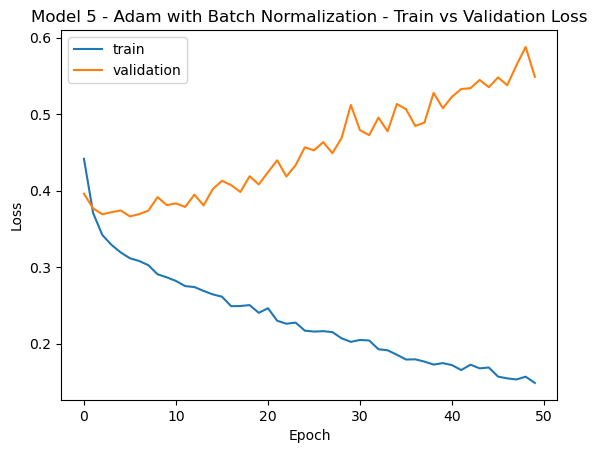

In [508]:
# plot Train Loss vs Validation Loss

plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.title('Model 5 - Adam with Batch Normalization - Train vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc=0)

plt.show()

### Model 5 - Adam with Batch Normalization | ROC-AUC Best Threshold

188/188 [==============================] - 0s 440us/step
Best Threshold=0.222470, G-Mean=0.957


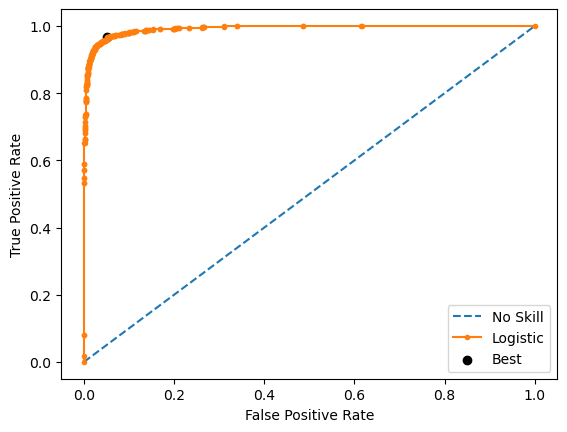

In [509]:
# predict probabilities
yhat5 = model5.predict(X_train)

# keep probabilties for positive outcomes only
yhat5 = yhat5[:, 0]

# calculate ROC curves
fpr, tpr, thresholds5 = roc_curve(y_train, yhat5)
# calculate the G-Mean for each threshold
gmeans5 = np.sqrt(tpr * (1 - fpr))
# locate the index of the largest G-Mean
ix = np.argmax((gmeans5))
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds5[ix], gmeans5[ix]))

# plot the ROC curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.show()

In [510]:
# predict using Best Threshold
y_pred5 = model5.predict(X_val)
y_pred5 = (y_pred5 > thresholds5[ix])
y_pred5

63/63 [==============================] - 0s 288us/step


array([[False],
       [False],
       [False],
       ...,
       [ True],
       [False],
       [False]])

### Model 5 - Adam with Batch Normalization | Confustion Matrix

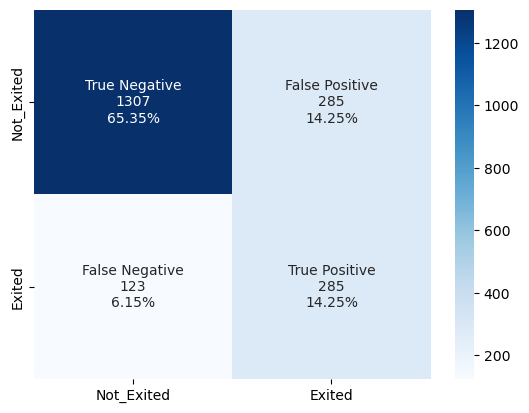

In [511]:
cm=confusion_matrix(y_val, y_pred3)
labels = ['True Negative','False Positive','False Negative','True Positive']
categories = [ 'Not_Exited','Exited']
make_confusion_matrix(cm, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

### Model 5 - Adam with Batch Normalization | Classification Report

In [512]:
# model 5 classification report
cr = metrics.classification_report(y_val, y_pred5)
print(cr)

              precision    recall  f1-score   support

           0       0.89      0.83      0.86      1592
           1       0.48      0.61      0.53       408

    accuracy                           0.78      2000
   macro avg       0.68      0.72      0.70      2000
weighted avg       0.81      0.78      0.79      2000



#### Model 5 Classification Report observations:

- Model 5 - Adam with Batch Normalization dropped to a **_61 percent_ `Recall` score**.
- This is below other previous models.
- Next, build an Adam Optimizer model with SMOTE balanced data techniques.

### Model 6 - Adam with SMOTE

**Apply SMOTE on Train dataset.**

In [524]:
# clear TF/Keras session
backend.clear_session()

# Fix random number seed for replication of results
np.random.seed(99)
random.seed(99)
tf.random.set_seed(99)

In [525]:
# Apply SMOTE on Train dataset
smote = SMOTE(sampling_strategy='not majority')
X_smote, y_smote = smote.fit_resample(X_train, y_train)

In [526]:
# build Model 6
model6 = Sequential()

model6.add(Dense(64, activation='relu', kernel_initializer='he_uniform', input_dim=X_train.shape[1]))
model6.add(Dropout(0.4))
model6.add(Dense(32, activation='relu'))
model6.add(Dropout(0.4))
model6.add(Dense(16, activation='relu'))
model6.add(Dense(1, activation='sigmoid'))

In [527]:
model6.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                896       
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 3521 (13.75 KB)
Trainable params: 3521 (13

### Model 6 - Fit Model using SMOTE dataset

In [528]:
optimizer = tf.keras.optimizers.Adam(grid_result.best_params_['lr'])
model6.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history6 = model6.fit(X_smote, y_smote, epochs=100, batch_size=grid_result.best_params_['batch_size'], validation_data=(X_val, y_val), verbose=1)

Epoch 1/100
150/150 [==============================] - 0s 831us/step - loss: 0.6060 - accuracy: 0.6825 - val_loss: 0.5294 - val_accuracy: 0.7305
Epoch 2/100
150/150 [==============================] - 0s 591us/step - loss: 0.5420 - accuracy: 0.7305 - val_loss: 0.5212 - val_accuracy: 0.7240
Epoch 3/100
150/150 [==============================] - 0s 494us/step - loss: 0.5120 - accuracy: 0.7530 - val_loss: 0.5103 - val_accuracy: 0.7645
Epoch 4/100
150/150 [==============================] - 0s 511us/step - loss: 0.4840 - accuracy: 0.7677 - val_loss: 0.4692 - val_accuracy: 0.7840
Epoch 5/100
150/150 [==============================] - 0s 511us/step - loss: 0.4610 - accuracy: 0.7842 - val_loss: 0.5279 - val_accuracy: 0.7625
Epoch 6/100
150/150 [==============================] - 0s 520us/step - loss: 0.4530 - accuracy: 0.7908 - val_loss: 0.4763 - val_accuracy: 0.7620
Epoch 7/100
150/150 [==============================] - 0s 517us/step - loss: 0.4408 - accuracy: 0.7955 - val_loss: 0.4851 - val_ac

### Model 6: Train vs Validation Loss

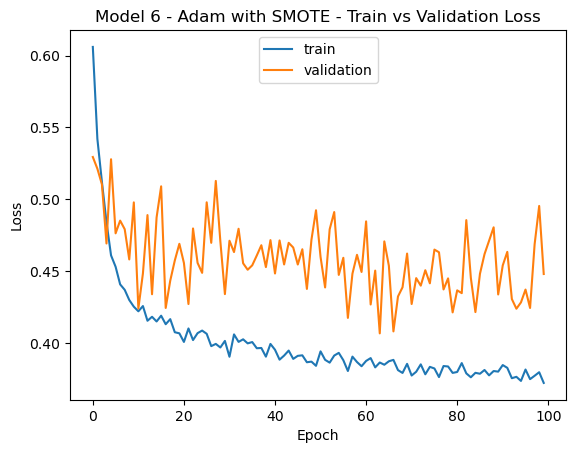

In [529]:
# plot Train Loss vs Validation Loss

plt.plot(history6.history['loss'])
plt.plot(history6.history['val_loss'])
plt.title('Model 6 - Adam with SMOTE - Train vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper center')

plt.show()

### Model 6 - ROC-AUC Best Threshold using SMOTE

299/299 [==============================] - 0s 232us/step
Best Threshold=0.453431, G-Mean=0.862


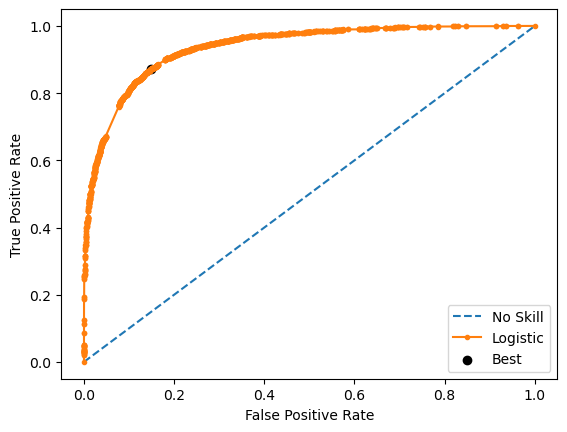

In [531]:
# predict probabilities
yhat6 = model6.predict(X_smote)

# keep probabilties for positive outcomes only
yhat6 = yhat6[:, 0]

# calculate ROC curves
fpr, tpr, thresholds6 = roc_curve(y_smote, yhat6)
# calculate the G-Mean for each threshold
gmeans6 = np.sqrt(tpr * (1 - fpr))
# locate the index of the largest G-Mean
ix = np.argmax((gmeans6))
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds6[ix], gmeans6[ix]))

# plot the ROC curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.show()

In [532]:
# predict using Best Threshold
y_pred6 = model6.predict(X_val)
y_pred6 = (y_pred6 > thresholds6[ix])
y_pred6

63/63 [==============================] - 0s 313us/step


array([[False],
       [False],
       [False],
       ...,
       [False],
       [ True],
       [False]])

### Model 6 - Confusion Matrix

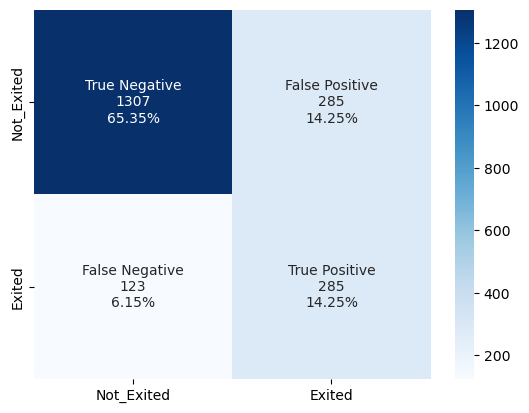

In [533]:
cm=confusion_matrix(y_val, y_pred3)
labels = ['True Negative','False Positive','False Negative','True Positive']
categories = [ 'Not_Exited','Exited']
make_confusion_matrix(cm, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

### Model 6 - Classification Report

In [534]:
# model 6 classification report
cr = metrics.classification_report(y_val, y_pred6)
print(cr)

              precision    recall  f1-score   support

           0       0.92      0.81      0.86      1592
           1       0.49      0.71      0.58       408

    accuracy                           0.79      2000
   macro avg       0.71      0.76      0.72      2000
weighted avg       0.83      0.79      0.81      2000



#### Model 6 - Classification Report observations:

- Model 6 **`Recall` score dropped to _71 percent_**.
- SMOTE using `non majority` and Dropout strategy did not improve results.
- Next, test best model against Test dataset and measure performance.

## Final Model

- Display **`Recall`** results for each model.
- Determine the final model to measure against Test dataset.

### Model `Recall` Performance

In [556]:
# display recall performance for each model.
print(f'Model 1 recall score: {recall_score(y_val, y_pred1) * 100:.3f} percent.')
print(f'Model 2 recall score: {recall_score(y_val, y_pred2) * 100:.3f} percent.')
print(f'Model 3 recall score: {recall_score(y_val, y_pred3) * 100:.3f} percent.')
print(f'Model 4 recall score: {recall_score(y_val, y_pred4) * 100:.3f} percent.')
print(f'Model 5 recall score: {recall_score(y_val, y_pred5) * 100:.3f} percent.')
print(f'Model 6 recall score: {recall_score(y_val, y_pred6) * 100:.3f} percent.')


Model 1 recall score: 47.304 percent.
Model 2 recall score: 74.510 percent.
Model 3 recall score: 69.853 percent.
Model 4 recall score: 75.490 percent.
Model 5 recall score: 61.029 percent.
Model 6 recall score: 71.324 percent.


### Model `Recall` observations:

```
Model 1 recall score: 47.304 percent.
Model 2 recall score: 74.510 percent.
Model 3 recall score: 69.853 percent.
>> Model 4 recall score: 75.490 percent. <<
Model 5 recall score: 61.029 percent.
Model 6 recall score: 71.324 percent.
```

- Model 4: Adam with Grid Search edged out Model 2.
- Measure Model 4 against the Test dataset.

### Model 4 vs Test dataset 

188/188 [==============================] - 0s 283us/step
Best Threshold=0.207647, G-Mean=0.815


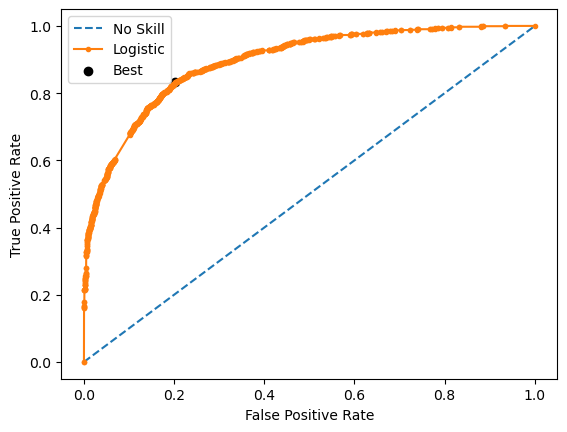

In [557]:
# predict probabilities
yhat4 = model4.predict(X_train)

# keep probabilties for positive outcomes only
yhat4 = yhat4[:, 0]

# calculate ROC curves
fpr, tpr, thresholds4 = roc_curve(y_train, yhat4)
# calculate the G-Mean for each threshold
gmeans4 = np.sqrt(tpr * (1 - fpr))
# locate the index of the largest G-Mean
ix = np.argmax((gmeans4))
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds4[ix], gmeans4[ix]))

# plot the ROC curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.show()

In [558]:
# predict Model 4 vs Test
y_pred_final = model4.predict(X_test)
y_pred_final = (y_pred_final > thresholds4[ix])
y_pred_final

63/63 [==============================] - 0s 273us/step


array([[False],
       [False],
       [False],
       ...,
       [False],
       [ True],
       [ True]])

### Final Model 4 vs Test Confusion Matrix

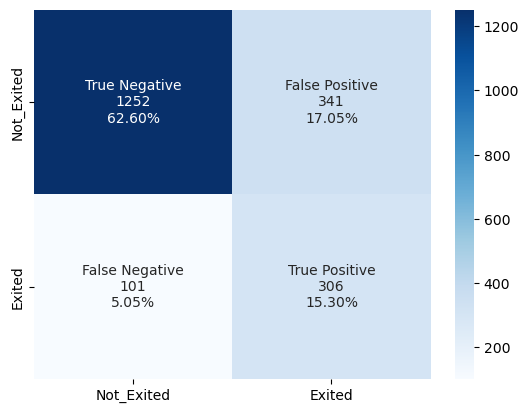

In [559]:
cm=confusion_matrix(y_test, y_pred_final)
labels = ['True Negative','False Positive','False Negative','True Positive']
categories = [ 'Not_Exited','Exited']
make_confusion_matrix(cm, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

### Final Model 4 vs Test Classification Repot

In [564]:
# Model 4 vs Test classification report
cr = metrics.classification_report(y_test, y_pred_final)
print(cr)

              precision    recall  f1-score   support

           0       0.93      0.79      0.85      1593
           1       0.47      0.75      0.58       407

    accuracy                           0.78      2000
   macro avg       0.70      0.77      0.72      2000
weighted avg       0.83      0.78      0.80      2000



In [566]:
print(f'Final Model 4 vs Test recall score: {recall_score(y_test, y_pred_final) * 100:.3f} percent.')

Final Model 4 vs Test recall score: 75.184 percent.


#### Model 4 vs Test observations:

- Model 4 **`Recall` score** performance held up against the Test dataset.
- The model should peform as well in production.

## Actionable Insights and Recommendations 

**What recommedations would you suggest to the bank?**

- Built and evaluated six (6) different models.
- The best performing model achieved **_75 percent_** `Recall` score.
- Recommend placing model in production to determine performance on current customers.


___